<a href="https://colab.research.google.com/github/svgoudar/kaggle_competetions/blob/main/regression/sol-house-prices-advanced-regression-techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Collection

In [ ]:
!pip install statsmodels seaborn matplotlib scikit-learn scipy xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import os
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import f_oneway
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor, PassiveAggressiveRegressor, RANSACRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance,mutual_info_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
import kagglehub
kagglehub.login()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
import kagglehub
house_prices_advanced_regression_techniques_path = kagglehub.competition_download('house-prices-advanced-regression-techniques')
print('Data source import complete.')


train_df = pd.read_csv(os.path.join(house_prices_advanced_regression_techniques_path, "train.csv"))

test_df = pd.read_csv(os.path.join(house_prices_advanced_regression_techniques_path, "test.csv"))

sample_submission = pd.read_csv(os.path.join(house_prices_advanced_regression_techniques_path, "sample_submission.csv"))

100%|██████████| 199k/199k [00:00<00:00, 524kB/s]

Extracting files...
Data source import complete.


In [ ]:
# train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
# test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


## Data Inspection

In [4]:
train_df.shape

(1460, 81)

In [5]:
train_df.describe(include='all').T


count unique     top  freq          mean           std  \
Id             1460.0    NaN     NaN   NaN         730.5    421.610009   
MSSubClass     1460.0    NaN     NaN   NaN      56.89726     42.300571   
MSZoning         1460      5      RL  1151           NaN           NaN   
LotFrontage    1201.0    NaN     NaN   NaN     70.049958     24.284752   
LotArea        1460.0    NaN     NaN   NaN  10516.828082   9981.264932   
...               ...    ...     ...   ...           ...           ...   
MoSold         1460.0    NaN     NaN   NaN      6.321918      2.703626   
YrSold         1460.0    NaN     NaN   NaN   2007.815753      1.328095   
SaleType         1460      9      WD  1267           NaN           NaN   
SaleCondition    1460      6  Normal  1198           NaN           NaN   
SalePrice      1460.0    NaN     NaN   NaN  180921.19589  79442.502883   

                   min       25%       50%       75%       max  
Id                 1.0    365.75     730.5   1095.25    1460.0  
MSSubClass        20.0      20.0      50.0      70.0     190.0  
MSZoning           NaN       NaN       NaN       NaN       NaN  
LotFrontage       21.0      59.0      69.0      80.0     313.0  
LotArea         1300.0    7553.5    9478.5   11601.5  215245.0  
...                ...       ...       ...       ...       ...  
MoSold             1.0       5.0       6.0       8.0      12.0  
YrSold          2006.0    2007.0    2008.0    2009.0    2010.0  
SaleType           NaN       NaN       NaN       NaN       NaN  
SaleCondition      NaN       NaN       NaN       NaN       NaN  
SalePrice      34900.0  129975.0  163000.0  214000.0  755000.0  

[81 rows x 11 columns]

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
train_df.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd        NaN   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng        NaN   
9          1950     Gable  CompShg     MetalSd     MetalSd        NaN   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9       

## Missing Value Analysis

In [8]:
cols_with_missing = train_df.columns[train_df.isnull().sum() > 0]

report = pd.DataFrame({
    "ColumnName": cols_with_missing,
    "MissingValues": train_df[cols_with_missing].isnull().sum().values,
    "MissingPercentage": round(train_df[cols_with_missing].isnull().mean() * 100, 2),
    "Dtype": train_df[cols_with_missing].dtypes.values,
    "Values": [train_df[col].value_counts(dropna=True).to_dict() for col in cols_with_missing]
})

report = report.sort_values(by="MissingValues", ascending=False).reset_index(drop=True)

report

ColumnName  MissingValues  MissingPercentage    Dtype  \
0         PoolQC           1453              99.52   object   
1    MiscFeature           1406              96.30   object   
2          Alley           1369              93.77   object   
3          Fence           1179              80.75   object   
4     MasVnrType            872              59.73   object   
5    FireplaceQu            690              47.26   object   
6    LotFrontage            259              17.74  float64   
7     GarageType             81               5.55   object   
8    GarageYrBlt             81               5.55  float64   
9   GarageFinish             81               5.55   object   
10    GarageQual             81               5.55   object   
11    GarageCond             81               5.55   object   
12  BsmtExposure             38               2.60   object   
13  BsmtFinType2             38               2.60   object   
14      BsmtQual             37               2.53   object   
15      BsmtCond             37               2.53   object   
16  BsmtFinType1             37               2.53   object   
17    MasVnrArea              8               0.55  float64   
18    Electrical              1               0.07   object   

                                               Values  
0                         {'Gd': 3, 'Ex': 2, 'Fa': 2}  
1       {'Shed': 49, 'Gar2': 2, 'Othr': 2, 'TenC': 1}  
2                            {'Grvl': 50, 'Pave': 41}  
3   {'MnPrv': 157, 'GdPrv': 59, 'GdWo': 54, 'MnWw'...  
4        {'BrkFace': 445, 'Stone': 128, 'BrkCmn': 15}  
5   {'Gd': 380, 'TA': 313, 'Fa': 33, 'Ex': 24, 'Po...  
6   {60.0: 143, 70.0: 70, 80.0: 69, 50.0: 57, 75.0...  
7   {'Attchd': 870, 'Detchd': 387, 'BuiltIn': 88, ...  
8   {2005.0: 65, 2006.0: 59, 2004.0: 53, 2003.0: 5...  
9                {'Unf': 605, 'RFn': 422, 'Fin': 352}  
10  {'TA': 1311, 'Fa': 48, 'Gd': 14, 'Ex': 3, 'Po'...  
11  {'TA': 1326, 'Fa': 35, 'Gd': 9, 'Po': 7, 'Ex': 2}  
12       {'No': 953, 'Av': 221, 'Gd': 134, 'Mn': 114}  
13  {'Unf': 1256, 'Rec': 54, 'LwQ': 46, 'BLQ': 33,...  
14        {'TA': 649, 'Gd': 618, 'Ex': 121, 'Fa': 35}  
15          {'TA': 1311, 'Gd': 65, 'Fa': 45, 'Po': 2}  
16  {'Unf': 430, 'GLQ': 418, 'ALQ': 220, 'BLQ': 14...  
17  {0.0: 861, 108.0: 8, 72.0: 8, 180.0: 8, 16.0: ...  
18  {'SBrkr': 1334, 'FuseA': 94, 'FuseF': 27, 'Fus...

In [9]:
# Calculate missing values
missing_data = train_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(train_df)) * 100

# Create a DataFrame to display missing data information
missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Missing Percentage': missing_percentage,
    'Dtype': train_df.dtypes
})

# Filter columns with missing data
missing_info = missing_info[missing_info['Missing Values'] > 0]
# print(missing_info)
#

# Define target variable
target = 'SalePrice'

# Results list
results = []

# Analyze impact of missing values on SalePrice
for col in missing_info.index:
    missing_indicator = train_df[col].isnull().astype(int)
    mean_missing = train_df.loc[missing_indicator == 1, target].mean()
    mean_present = train_df.loc[missing_indicator == 0, target].mean()
    results.append({
        'Feature': col,
        'Missing %': missing_percentage[col],
        'Mean SalePrice (Missing)': mean_missing,
        'Mean SalePrice (Present)': mean_present,
        'Difference': mean_present - mean_missing
    })

# Create a DataFrame for the results
impact_df = pd.DataFrame(results).sort_values(by='Difference', ascending=False)
impact_df


Feature  Missing %  Mean SalePrice (Missing)  \
18        PoolQC  99.520548             180404.663455   
9     GarageCond   5.547945             103317.283951   
11    GarageQual   5.547945             103317.283951   
12    GarageType   5.547945             103317.283951   
13   GarageYrBlt   5.547945             103317.283951   
10  GarageFinish   5.547945             103317.283951   
1       BsmtCond   2.534247             105652.891892   
3   BsmtFinType1   2.534247             105652.891892   
5       BsmtQual   2.534247             105652.891892   
8    FireplaceQu  47.260274             141331.482609   
2   BsmtExposure   2.602740             107938.342105   
4   BsmtFinType2   2.602740             110346.236842   
16    MasVnrType  59.726027             156958.243119   
6     Electrical   0.068493             167500.000000   
14   LotFrontage  17.739726             181620.073359   
17   MiscFeature  96.301370             182046.410384   
7          Fence  80.753425             187596.837998   
0          Alley  93.767123             183452.131483   
15    MasVnrArea   0.547945             236484.250000   

    Mean SalePrice (Present)     Difference  
18             288138.571429  107733.907974  
9              185479.511240   82162.227289  
11             185479.511240   82162.227289  
12             185479.511240   82162.227289  
13             185479.511240   82162.227289  
10             185479.511240   82162.227289  
1              182878.277583   77225.385691  
3              182878.277583   77225.385691  
5              182878.277583   77225.385691  
8              216397.692208   75066.209599  
2              182871.511252   74933.169146  
4              182807.165260   72460.928418  
16             216458.091837   59499.848717  
6              180930.394791   13430.394791  
14             180770.480433    -849.592926  
17             151623.944444  -30422.465940  
7              152912.007117  -34684.830881  
0              142845.912088  -40606.219395  
15             180615.063361  -55869.186639

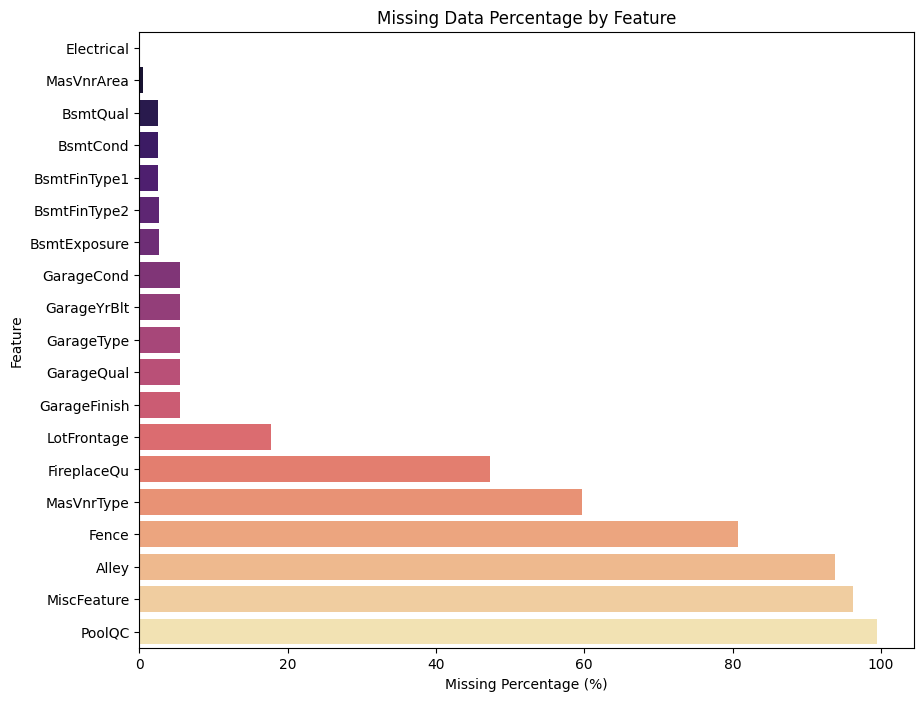

In [10]:
missing_info_sorted = missing_info.sort_values(by='Missing Percentage', ascending=True)

plt.figure(figsize=(10,8))
sbn.barplot(x='Missing Percentage', y=missing_info_sorted.index, data=missing_info_sorted, palette='magma')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Feature')
plt.title('Missing Data Percentage by Feature')
plt.show()


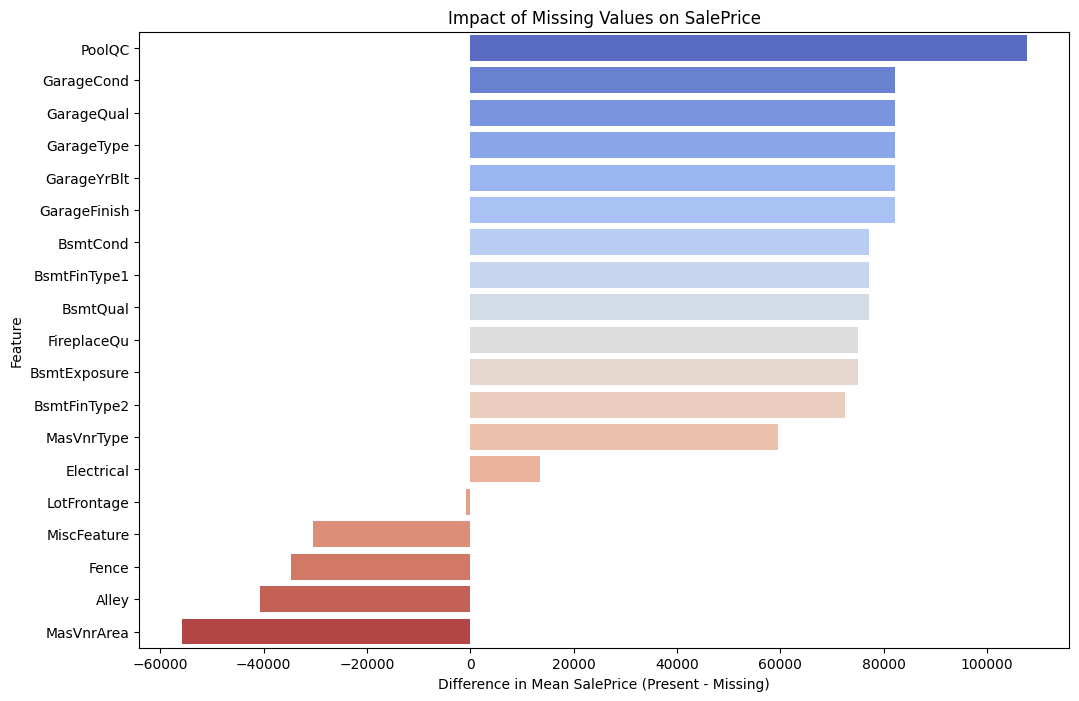

In [11]:
# Plot the impact of missing values on SalePrice
plt.figure(figsize=(12, 8))
sbn.barplot(x='Difference', y='Feature', data=impact_df, palette='coolwarm')
plt.title('Impact of Missing Values on SalePrice')
plt.xlabel('Difference in Mean SalePrice (Present - Missing)')
plt.ylabel('Feature')
plt.show()

**The above insights do not validate or confirm the missing value analysis.**

### 5. Decide Strategy

* **>80% missing** → drop column (low signal).
* **<5–10% missing** → impute (median/mean for numeric, mode for categorical).
* **Domain-driven missingness** → treat as a category (e.g., `GarageType=NA` means *no garage*).
* **Flagging** → add indicator column to capture predictive signal of missingness.

In [12]:
!pip install missingno

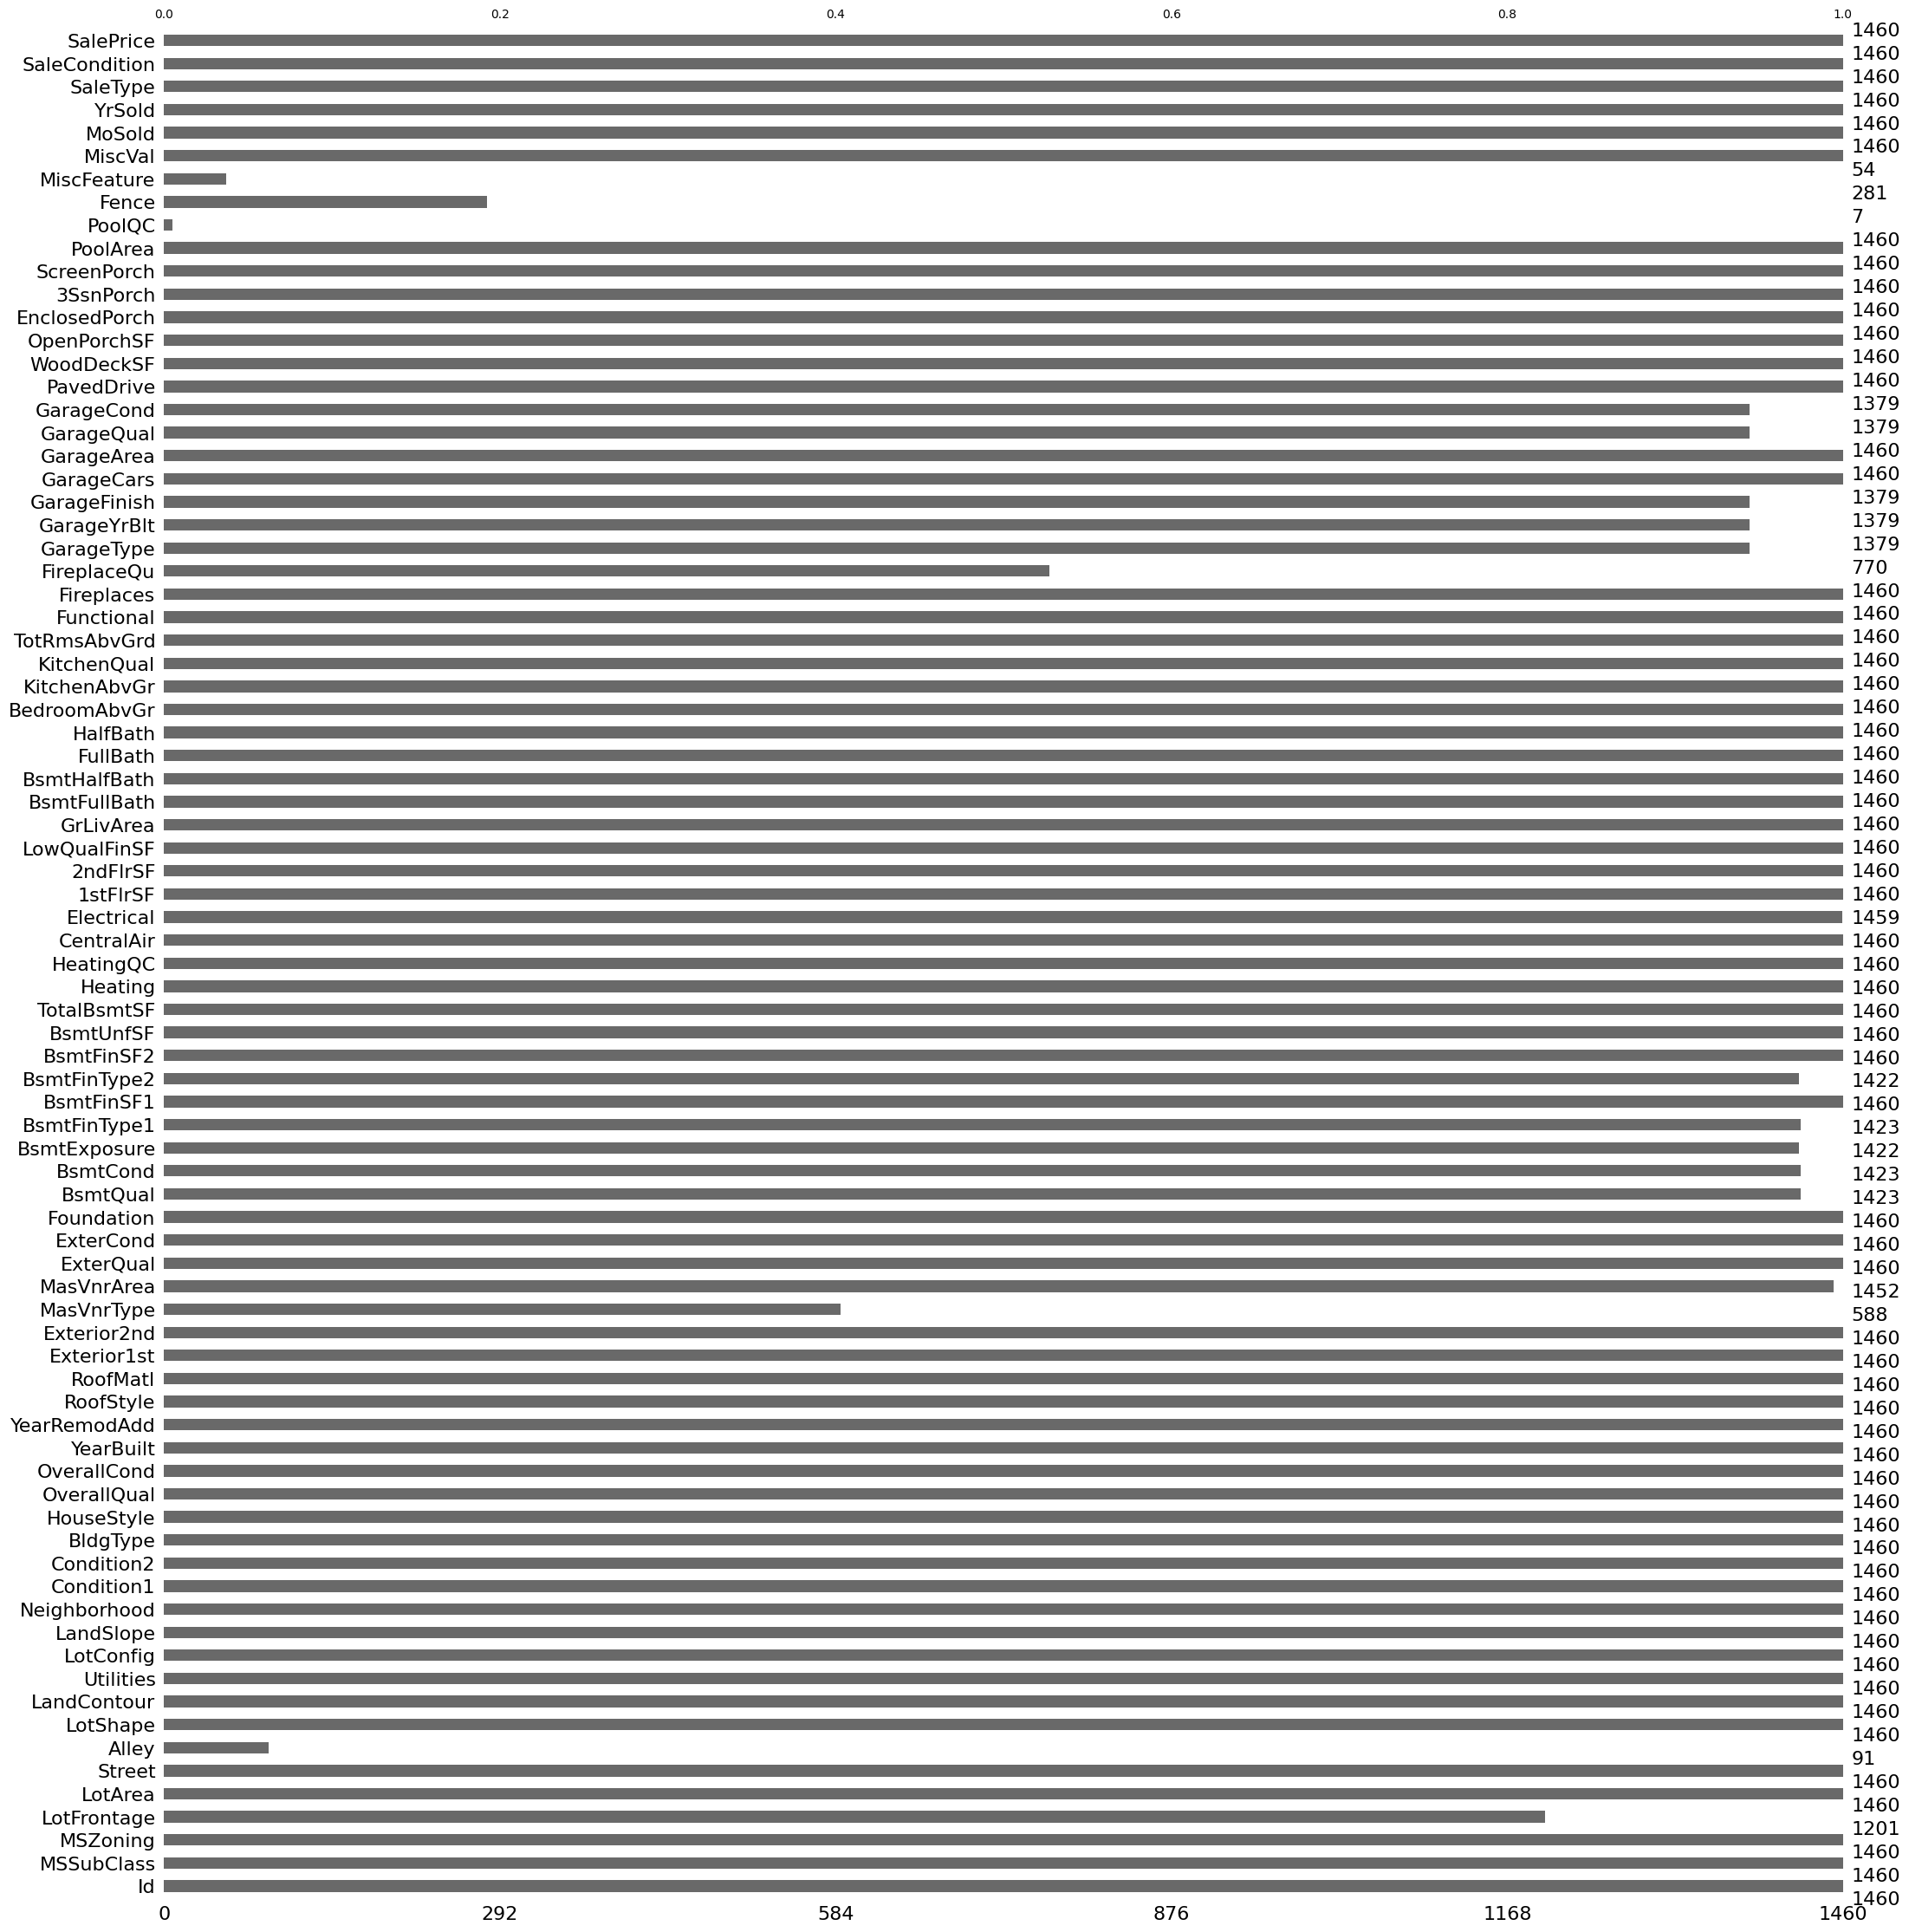

In [13]:
import missingno as msno
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
msno.bar(train_df)
plt.show()

In [14]:
missing_data = train_df.isnull().sum().reset_index()
missing_data = missing_data.rename(columns={"index":"columns",0:"count"})
missing_data['dtype'] = train_df.dtypes.values
missing_data.groupby("dtype").count()

columns  count
dtype                  
int64         35     35
float64        3      3
object        43     43

In [15]:
missing_data['values'] = [train_df[col].value_counts(dropna=True).to_dict() for col in train_df.columns.to_list()]

In [16]:
missing_data.sort_values(by='count',ascending=False).T

72  \
columns                       PoolQC   
count                           1453   
dtype                         object   
values   {'Gd': 3, 'Ex': 2, 'Fa': 2}   

                                                    74  \
columns                                    MiscFeature   
count                                             1406   
dtype                                           object   
values   {'Shed': 49, 'Gar2': 2, 'Othr': 2, 'TenC': 1}   

                               6   \
columns                     Alley   
count                        1369   
dtype                      object   
values   {'Grvl': 50, 'Pave': 41}   

                                                        73  \
columns                                              Fence   
count                                                 1179   
dtype                                               object   
values   {'MnPrv': 157, 'GdPrv': 59, 'GdWo': 54, 'MnWw'...   

                                                   25  \
columns                                    MasVnrType   
count                                             872   
dtype                                          object   
values   {'BrkFace': 445, 'Stone': 128, 'BrkCmn': 15}   

                                                        57  \
columns                                        FireplaceQu   
count                                                  690   
dtype                                               object   
values   {'Gd': 380, 'TA': 313, 'Fa': 33, 'Ex': 24, 'Po...   

                                                        3   \
columns                                        LotFrontage   
count                                                  259   
dtype                                              float64   
values   {60.0: 143, 70.0: 70, 80.0: 69, 50.0: 57, 75.0...   

                                                        63  \
columns                                         GarageQual   
count                                                   81   
dtype                                               object   
values   {'TA': 1311, 'Fa': 48, 'Gd': 14, 'Ex': 3, 'Po'...   

                                           60  \
columns                          GarageFinish   
count                                      81   
dtype                                  object   
values   {'Unf': 605, 'RFn': 422, 'Fin': 352}   

                                                        58  \
columns                                         GarageType   
count                                                   81   
dtype                                               object   
values   {'Attchd': 870, 'Detchd': 387, 'BuiltIn': 88, ...   

                                                        59  \
columns                                        GarageYrBlt   
count                                                   81   
dtype                                              float64   
values   {2005.0: 65, 2006.0: 59, 2004.0: 53, 2003.0: 5...   

                                                        64  \
columns                                         GarageCond   
count                                                   81   
dtype                                               object   
values   {'TA': 1326, 'Fa': 35, 'Gd': 9, 'Po': 7, 'Ex': 2}   

                                                        35  \
columns                                       BsmtFinType2   
count                                                   38   
dtype                                               object   
values   {'Unf': 1256, 'Rec': 54, 'LwQ': 46, 'BLQ': 33,...   

                                                   32  \
columns                                  BsmtExposure   
count                                              38   
dtype                                          object   
values   {'No': 953, 'Av': 221, 'Gd': 134, 'Mn': 114}   

                                                31

In [17]:
summary = train_df.isnull().sum().sort_values(ascending=False)
summary = summary[summary >0]
report = pd.DataFrame({
    "MissingValues": summary,
    "Dtype": train_df[summary.index].dtypes
})

# Add value_counts as dictionary for each column
report["ValueCounts"] = report.index.map(
    lambda col: train_df[col].value_counts().to_dict()
)

report


MissingValues    Dtype  \
PoolQC                 1453   object   
MiscFeature            1406   object   
Alley                  1369   object   
Fence                  1179   object   
MasVnrType              872   object   
FireplaceQu             690   object   
LotFrontage             259  float64   
GarageQual               81   object   
GarageFinish             81   object   
GarageType               81   object   
GarageYrBlt              81  float64   
GarageCond               81   object   
BsmtFinType2             38   object   
BsmtExposure             38   object   
BsmtCond                 37   object   
BsmtQual                 37   object   
BsmtFinType1             37   object   
MasVnrArea                8  float64   
Electrical                1   object   

                                                    ValueCounts  
PoolQC                              {'Gd': 3, 'Ex': 2, 'Fa': 2}  
MiscFeature       {'Shed': 49, 'Gar2': 2, 'Othr': 2, 'TenC': 1}  
Alley                                  {'Grvl': 50, 'Pave': 41}  
Fence         {'MnPrv': 157, 'GdPrv': 59, 'GdWo': 54, 'MnWw'...  
MasVnrType         {'BrkFace': 445, 'Stone': 128, 'BrkCmn': 15}  
FireplaceQu   {'Gd': 380, 'TA': 313, 'Fa': 33, 'Ex': 24, 'Po...  
LotFrontage   {60.0: 143, 70.0: 70, 80.0: 69, 50.0: 57, 75.0...  
GarageQual    {'TA': 1311, 'Fa': 48, 'Gd': 14, 'Ex': 3, 'Po'...  
GarageFinish               {'Unf': 605, 'RFn': 422, 'Fin': 352}  
GarageType    {'Attchd': 870, 'Detchd': 387, 'BuiltIn': 88, ...  
GarageYrBlt   {2005.0: 65, 2006.0: 59, 2004.0: 53, 2003.0: 5...  
GarageCond    {'TA': 1326, 'Fa': 35, 'Gd': 9, 'Po': 7, 'Ex': 2}  
BsmtFinType2  {'Unf': 1256, 'Rec': 54, 'LwQ': 46, 'BLQ': 33,...  
BsmtExposure       {'No': 953, 'Av': 221, 'Gd': 134, 'Mn': 114}  
BsmtCond              {'TA': 1311, 'Gd': 65, 'Fa': 45, 'Po': 2}  
BsmtQual            {'TA': 649, 'Gd': 618, 'Ex': 121, 'Fa': 35}  
BsmtFinType1  {'Unf': 430, 'GLQ': 418, 'ALQ': 220, 'BLQ': 14...  
MasVnrArea    {0.0: 861, 108.0: 8, 72.0: 8, 180.0: 8, 16.0: ...  
Electrical    {'SBrkr': 1334, 'FuseA': 94, 'FuseF': 27, 'Fus...

In [18]:
df_before_clean = train_df.copy()

<Axes: xlabel='LotFrontage', ylabel='Count'>

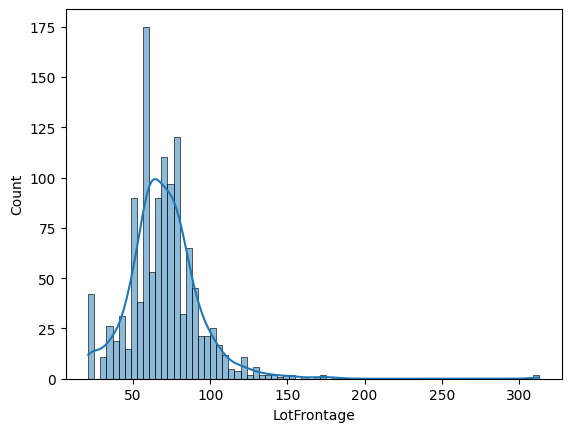

In [19]:
sbn.histplot(df_before_clean['LotFrontage'],kde=True)

## Data Cleaning Pipeline

In [20]:
category_columns = df_before_clean.select_dtypes(include=['object']).columns.to_list()
num_columns = df_before_clean.select_dtypes(include=['int64','float64']).columns.to_list()
high_cardinal_cat_columns = [col for col in category_columns if df_before_clean[col].nunique() > 10]
low_cardinal_cat_columns = [col for col in category_columns if df_before_clean[col].nunique() <= 10]

In [21]:
text_cols = [col for col in df_before_clean.columns
             if df_before_clean[col].dtype == 'object' and df_before_clean[col].dropna().apply(lambda x: isinstance(x, str) and len(x.split()) > 2).any()]

print(text_cols)

[]


In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np


class SkewedImputerMixin:
    def _numeric_imputer_strategy(self, df, skew_threshold=0.5):
        """Determine imputation strategy based on skewness for numerical columns"""
        # Exclude Id column if present
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        self.numeric_strategies = {}
        for col in numeric_cols:
            # Handle columns with all NaN values
            if df[col].notna().sum() == 0:
                self.numeric_strategies[col] = "median"
                continue

            skewness = df[col].skew()
            # Use median for skewed data, mean for normal distribution
            strategy = "median" if abs(skewness) > skew_threshold else "mean"
            self.numeric_strategies[col] = strategy
        return numeric_cols


class MissingValueAnalyzerMixin:
    def analyze(self, df):
        """Analyze missing values and determine handling strategy"""
        self.data = df.copy()
        cols_with_missing = df.columns[df.isnull().sum() > 0]

        if len(cols_with_missing) == 0:
            print("No missing values found in the dataset.")
            self.sparse_columns = []
            return pd.DataFrame()

        report = pd.DataFrame(
            {
                "ColumnName": cols_with_missing,
                "MissingValues": df[cols_with_missing].isnull().sum().values,
                "MissingPercentage": round(
                    df[cols_with_missing].isnull().mean() * 100, 2
                ),
                "Dtype": df[cols_with_missing].dtypes.values,
                "UniqueValues": [
                    df[col].nunique(dropna=True) for col in cols_with_missing
                ],
            }
        ).sort_values(by="MissingPercentage", ascending=False)

        # Decide strategy based on missing percentage
        report["Strategy"] = report["MissingPercentage"].apply(
            lambda pct: "Drop Column" if pct > 80 else "Impute"
        )
        print("SUMMMARY")
        print(report)
        # Store columns to be dropped
        self.sparse_columns.extend(
            report.loc[report["Strategy"] == "Drop Column", "ColumnName"].tolist()
        )

        print(f"Found {len(cols_with_missing)} columns with missing values.")
        print(f"Columns to drop (>80% missing): {len(self.sparse_columns)}")

        return report


class ImputerPipelineMixin:
    def build_imputer_pipeline(self, df, cardinality_threshold=10, skew_threshold=0.5):
        """Build preprocessing pipeline with appropriate imputers for different column types"""
        # Drop sparse columns (>80% missing)
        df_clean = df.drop(columns=getattr(self, "sparse_columns", []), errors="ignore")
        print(f"Dropped {len(getattr(self, 'sparse_columns', []))} sparse columns")

        # Get numeric columns and their strategies
        numeric_cols = self._numeric_imputer_strategy(df_clean, skew_threshold)
        numeric_strategies = getattr(self, "numeric_strategies", {})

        # Get categorical columns and split by cardinality
        cat_cols = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()
        low_card_cols = [
            col
            for col in cat_cols
            if df_clean[col].nunique(dropna=False) <= cardinality_threshold
        ]
        high_card_cols = [
            col
            for col in cat_cols
            if df_clean[col].nunique(dropna=False) > cardinality_threshold
        ]

        print(f"Numeric columns: {len(numeric_cols)}")
        print(f"Low cardinality categorical: {len(low_card_cols)}")
        print(f"High cardinality categorical: {len(high_card_cols)}")

        # Build transformers list
        transformers = []

        # Numeric transformer with skew-aware imputation
        if numeric_cols:

            def skewed_imputer(X):
                """Custom imputer that handles skewed numeric data"""
                if len(X.shape) == 1:
                    X = X.reshape(-1, 1)

                X_df = pd.DataFrame(X, columns=numeric_cols[: X.shape[1]])

                for i, col in enumerate(numeric_cols[: X.shape[1]]):
                    strategy = numeric_strategies.get(col, "median")
                    imputer = SimpleImputer(strategy=strategy)
                    X_df.iloc[:, [i]] = imputer.fit_transform(X_df.iloc[:, [i]])

                return X_df.values

            numeric_pipeline = FunctionTransformer(skewed_imputer, validate=False)
            transformers.append(("numeric", numeric_pipeline, numeric_cols))

        # Low cardinality categorical transformer
        if low_card_cols:
            low_card_pipeline = Pipeline(
                [("imputer", SimpleImputer(strategy="most_frequent"))]
            )
            transformers.append(("low_card", low_card_pipeline, low_card_cols))

        # High cardinality categorical transformer
        if high_card_cols:
            high_card_pipeline = Pipeline(
                [("imputer", SimpleImputer(strategy="constant", fill_value="Unknown"))]
            )
            transformers.append(("high_card", high_card_pipeline, high_card_cols))

        # Create ColumnTransformer
        if not transformers:
            raise ValueError("No valid columns found for preprocessing")

        preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder="drop",  # Drop any remaining columns
            sparse_threshold=0,  # Return dense array
        )

        # Store pipeline information
        self.pipeline_info = {
            "numeric": numeric_cols,
            "low_card": low_card_cols,
            "high_card": high_card_cols,
            "dropped": getattr(self, "sparse_columns", []),
            "all_processed": numeric_cols + low_card_cols + high_card_cols,
        }

        return preprocessor


class Preprocessor(
    SkewedImputerMixin,
    MissingValueAnalyzerMixin,
    ImputerPipelineMixin,
    BaseEstimator,
    TransformerMixin,
):
    def __init__(
        self,
        cardinality_threshold=10,
        skew_threshold=0.5,
        sparse_columns=[],
        retain_columns=[],
    ):
        self.cardinality_threshold = cardinality_threshold
        self.skew_threshold = skew_threshold
        self.sparse_columns = sparse_columns
        self.retain_columns = retain_columns

    def fit(self, X, y=None):
        """Fit the preprocessor to the training data"""
        if self.sparse_columns and self.sparse_columns in X.columns.to_list():
            X.drop(columns=self.sparse_columns, inplace=True, axis=1)
        if self.retain_columns:
            X = X[self.retain_columns]

        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        print(f"🔄 Fitting DataPreprocessor on data with shape: {X.shape}")

        try:
            # Step 1: Analyze missing values and identify sparse columns
            print("Step 1: Analyzing missing values...")
            self.analyze(X)

            # Step 2: Determine numeric imputation strategies based on skewness
            print("Step 2: Determining numeric imputation strategies...")
            self._numeric_imputer_strategy(X, self.skew_threshold)

            # Step 3: Build and fit the preprocessing pipeline
            print("Step 3: Building preprocessing pipeline...")
            self.imputer_pipeline = self.build_imputer_pipeline(
                X, self.cardinality_threshold, self.skew_threshold
            )

            print("Step 4: Fitting pipeline...")
            self.imputer_pipeline.fit(X)

            print("✅ DataPreprocessor fitted successfully!")
            return self

        except Exception as e:
            print(f"❌ Error during fitting: {e}")
            raise

    def transform(self, X):
        """Transform the input data using the fitted pipeline"""
        if not hasattr(self, "imputer_pipeline"):
            raise ValueError("Pipeline not fitted. Call fit() first.")

        # Apply transformation
        X_transformed = self.imputer_pipeline.transform(X)

        # Get column names in the correct order
        all_cols = self.pipeline_info["all_processed"]

        # Validate dimensions
        if X_transformed.shape[1] != len(all_cols):
            print(f"Warning: Shape mismatch!")
            print(f"X_transformed shape: {X_transformed.shape}")
            print(f"Expected columns: {len(all_cols)}")
            print(f"Using generic column names...")
            # all_cols = [f"feature_{i}" for i in range(X_transformed.shape[1])]

        # Convert to DataFrame
        try:
            X_transformed_df = pd.DataFrame(
                X_transformed, columns=all_cols, index=X.index
            )
            X_transformed_df = X_transformed_df.astype(
                X.loc[:, X_transformed_df.columns].dtypes.to_dict()
            )
            print(f"✅ Successfully transformed to DataFrame: {X_transformed_df.shape}")
            return X_transformed_df

        except Exception as e:
            print(f"❌ Error creating DataFrame: {e}")
            return X_transformed

    def get_feature_names_out(self):
        """Get the names of the output features after transformation"""
        if hasattr(self, "pipeline_info"):
            return self.pipeline_info["all_processed"]
        else:
            raise ValueError("Pipeline not fitted yet. Call fit() first.")

    def fit_transform(self, X, y=None):
        """Fit the transformer and transform the data in one step"""
        return self.fit(X, y).transform(X)

    def get_pipeline_summary(self):
        """Get a summary of the preprocessing pipeline"""
        if not hasattr(self, "pipeline_info"):
            return "Pipeline not fitted yet."

        summary = {
            "Total features processed": len(self.pipeline_info["all_processed"]),
            "Numeric features": len(self.pipeline_info["numeric"]),
            "Low cardinality categorical": len(self.pipeline_info["low_card"]),
            "High cardinality categorical": len(self.pipeline_info["high_card"]),
            "Dropped features": len(self.pipeline_info["dropped"]),
        }

        return summary


In [23]:
df_before_clean

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1455       Norm     1Fam     2Story            6            5       1999   
1456       Norm     1Fam     1Story            6            6       1978   
1457       Norm     1Fam     2Story            7            9       1941   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1455          2000     Gable  CompShg     VinylSd     VinylSd        NaN   
1456          1988     Gable  CompShg     Plywood     Plywood      Stone   
1457          2006     Gable  CompShg     CemntBd     CmentBd        NaN   
1458          1996       Hip  CompShg     MetalSd     MetalSd        NaN   
1459          1965     Gable  CompShg     HdBoard     HdBoard        NaN   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0          196.0        Gd        TA      PConc       Gd       TA   
1            0.0        TA        TA     CBlock       Gd       TA   
2          162.0        Gd        TA      PConc       Gd       TA   
3            0.0        TA        TA     BrkTil       TA       Gd   

In [24]:
preprocessor = Preprocessor(skew_threshold=0.5, cardinality_threshold=10,sparse_columns=['Id'])
df_clean = preprocessor.fit_transform(df_before_clean)

# print(cleaned_df.dtypes)
df_clean.isnull().sum()

🔄 Fitting DataPreprocessor on data with shape: (1460, 81)
Step 1: Analyzing missing values...
SUMMMARY
                ColumnName  MissingValues  MissingPercentage    Dtype  \
PoolQC              PoolQC           1453              99.52   object   
MiscFeature    MiscFeature           1406              96.30   object   
Alley                Alley           1369              93.77   object   
Fence                Fence           1179              80.75   object   
MasVnrType      MasVnrType            872              59.73   object   
FireplaceQu    FireplaceQu            690              47.26   object   
LotFrontage    LotFrontage            259              17.74  float64   
GarageType      GarageType             81               5.55   object   
GarageYrBlt    GarageYrBlt             81               5.55  float64   
GarageFinish  GarageFinish             81               5.55   object   
GarageQual      GarageQual             81               5.55   object   
GarageCond      Garag

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
                ..
SaleType         0
SaleCondition    0
Neighborhood     0
Exterior1st      0
Exterior2nd      0
Length: 76, dtype: int64

In [25]:
df_clean

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1455          60         62.0     7917            6            5       1999   
1456          20         85.0    13175            6            6       1978   
1457          70         66.0     9042            7            9       1941   
1458          20         68.0     9717            5            6       1950   
1459          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0             2003       196.0         706           0        150   
1             1976         0.0         978           0        284   
2             2002       162.0         486           0        434   
3             1970         0.0         216           0        540   
4             2000       350.0         655           0        490   
...            ...         ...         ...         ...        ...   
1455          2000         0.0           0           0        953   
1456          1988       119.0         790         163        589   
1457          2006         0.0         275           0        877   
1458          1996         0.0          49        1029          0   
1459          1965         0.0         830         290        136   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0             856       856       854             0       1710             1   
1            1262      1262         0             0       1262             0   
2             920       920       866             0       1786             1   
3             756       961       756             0       1717             1   
4            1145      1145      1053             0       2198             1   
...           ...       ...       ...           ...        ...           ...   
1455          953       953       694             0       1647             0   
1456         1542      2073         0             0       2073             1   
1457         1152      1188      1152             0       2340             0   
1458         1078      1078         0             0       1078             1   
1459         1256      1256         0             0       1256             1   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0                0         2         1             3             1   
1                1         2         0             3             1   
2                0         2         1             3             1   
3                0         1         0             3             1   
4                0         2         1             4             1   
...            ...       ...       ...           ...           ...   
1455             0         2         1             3             1   
1456             0         2         0             3             1   
1457             0         2         0             4             1   
1458             0         1         0             2             1   
1459             0         1         1             3             1   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
0                8           0       2003.0           2         548   
1                6           1       1976.0           2         460   
2                6           1       2001.0           2         608   
3                7           1       1998.0           3         642   
4                9           1       2000.0           3         836   


In [26]:
df_clean.isnull().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
                ..
SaleType         0
SaleCondition    0
Neighborhood     0
Exterior1st      0
Exterior2nd      0
Length: 76, dtype: int64

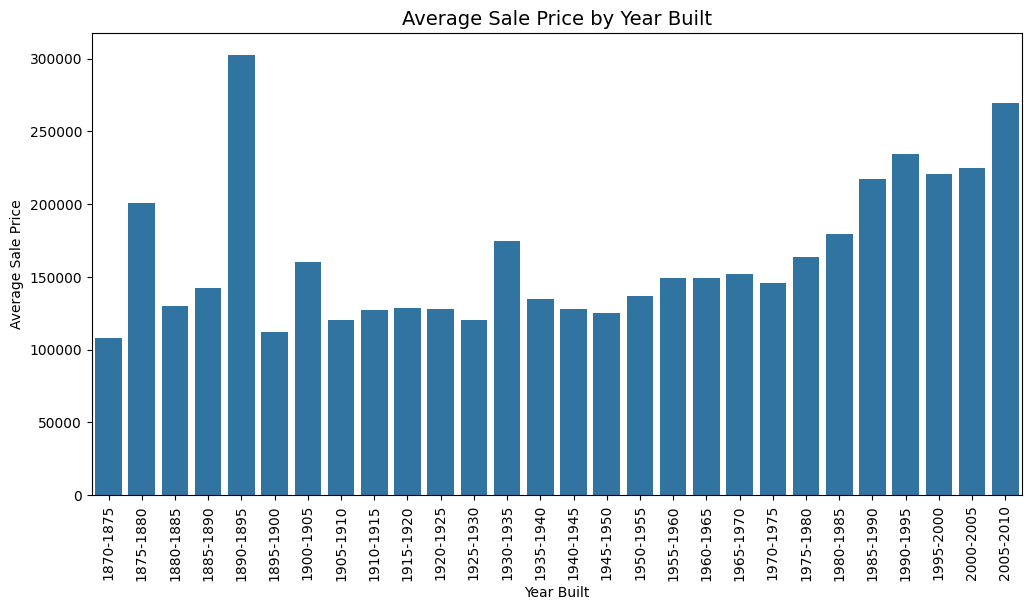

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

yearbuiltbin = pd.cut(
    df_clean["YearBuilt"],
    bins=range(1870, 2015, 5),   # bins of 5 years
    labels=[f"{y}-{y+5}" for y in range(1870, 2010, 5)]
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x=yearbuiltbin,
    y=df_clean['SalePrice'],
    errorbar=None,   # removes confidence intervals if not needed
    estimator="mean" # default is mean, but you can set "median"
)
plt.xticks(rotation=90)  # rotate labels if too many years
plt.title("Average Sale Price by Year Built", fontsize=14)
plt.xlabel("Year Built")
plt.ylabel("Average Sale Price")
plt.show()


In [28]:
summary = df_clean.isnull().sum()
summary[summary > 0]

Series([], dtype: int64)

## **Feature analysis with Data Visualization**

### **Univariate Analysis**

#### Numerical Feature

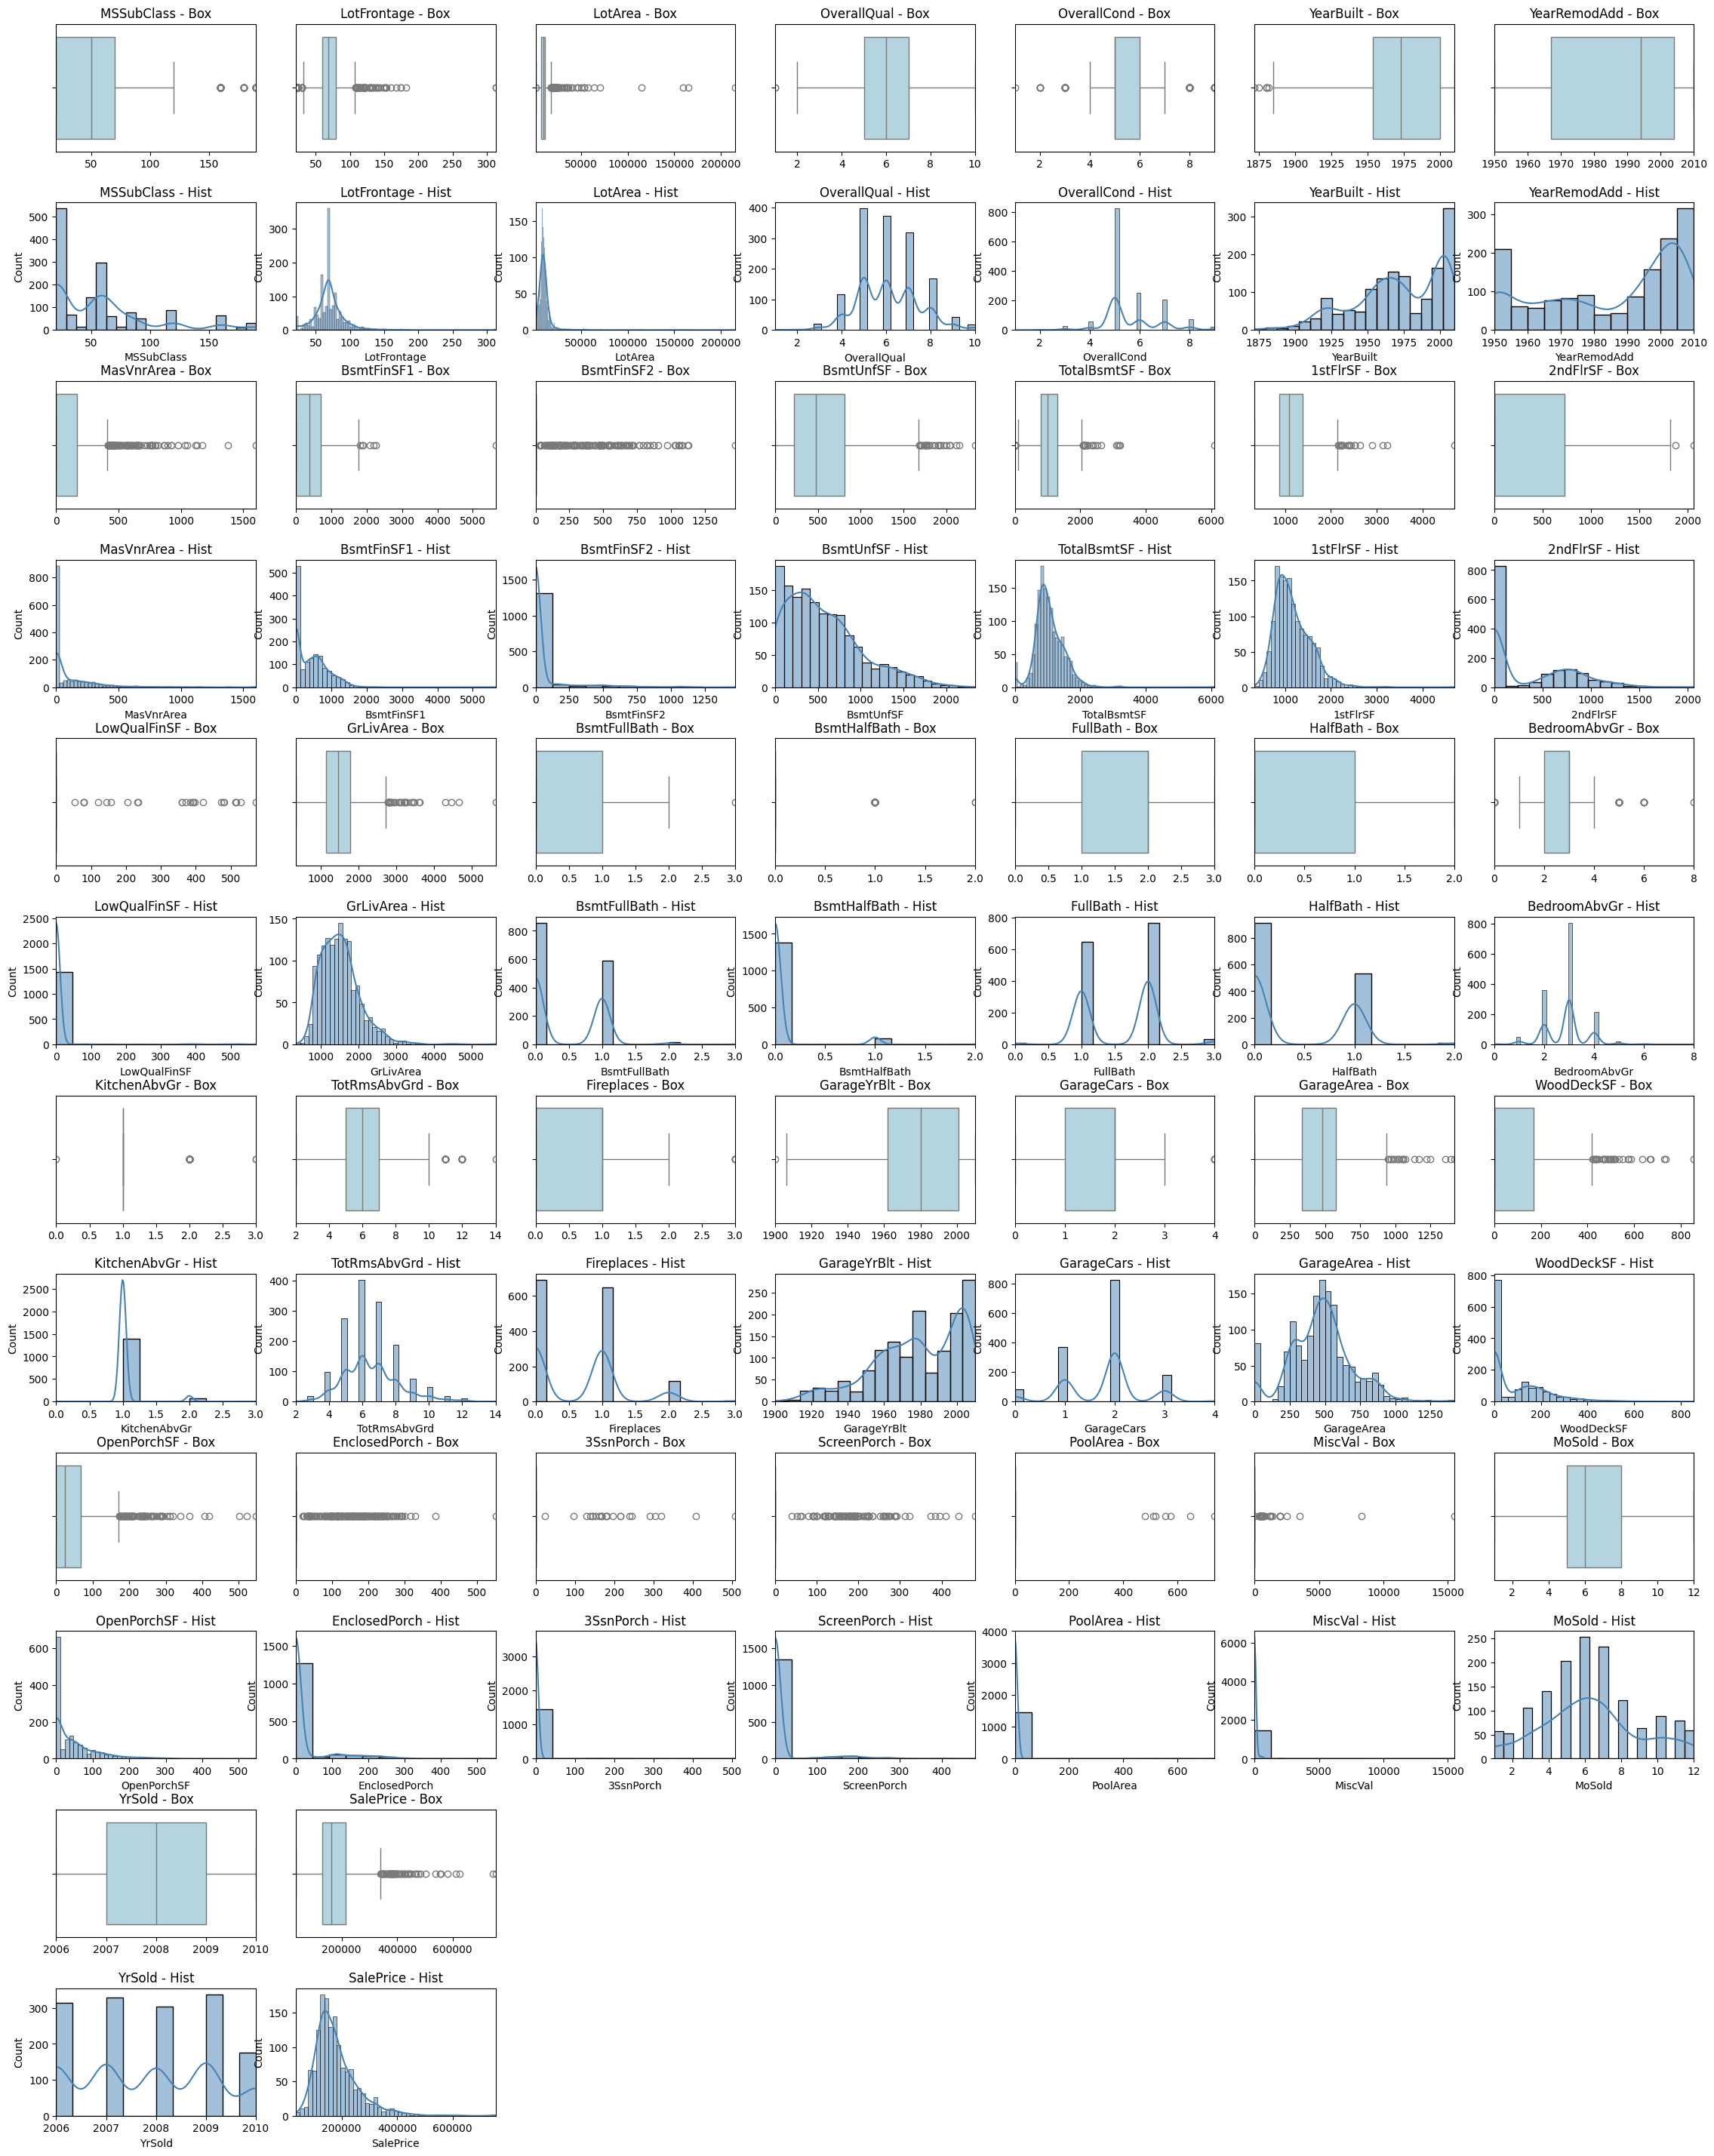

In [29]:
num_columns = df_clean.select_dtypes(include=['int64','float64','int32']).columns.to_list()
n = len(num_columns)
n_cols = int(np.ceil(np.sqrt(n)))
n_rows = int(np.ceil(n / n_cols))


# Flatten for indexing
# axes = axes.flatten()

n_cols = int(np.ceil(np.sqrt(n)))
n_rows = int(np.ceil(n / n_cols))
fig = plt.figure(figsize=(4*n_cols, 3*n_rows*2))
gs = fig.add_gridspec(n_rows*2, n_cols, hspace=0.4)

for i, col in enumerate(num_columns):
    r = (i // n_cols) * 2  # row start (two rows per feature)
    c = i % n_cols

    # Determine shared x-axis limits
    xmin, xmax = df_clean[col].min(), df_clean[col].max()

    # Boxplot (top)
    ax_box = fig.add_subplot(gs[r, c])
    sns.boxplot(x=df_clean[col], ax=ax_box, color="lightblue")
    ax_box.set_title(f"{col} - Box")
    ax_box.set_xlim(xmin, xmax)
    ax_box.set_xlabel("")

    # Histogram (bottom)
    ax_hist = fig.add_subplot(gs[r+1, c], sharex=ax_box)
    sns.histplot(df_clean[col], kde=True, ax=ax_hist, color="steelblue")
    ax_hist.set_title(f"{col} - Hist")
    ax_hist.set_xlim(xmin, xmax)

plt.tight_layout()
plt.show()

**The plots show that none of the features, including the target `SalePrice`, follow a normal distribution. These need transformation into near-normal distributions using methods such as Log, Box-Cox, or Yeo–Johnson. Before applying transformations, identify the most correlated features**

#### Categorical Feature

In [30]:
category_columns = df_clean.select_dtypes(include=['object']).columns.to_list()
num_columns = df_clean.select_dtypes(include=['int64','float64','int32']).columns.to_list()
high_cardinal_cat_columns = [col for col in category_columns if df_clean[col].nunique() > 10]
low_cardinal_cat_columns = [col for col in category_columns if df_clean[col].nunique() <= 10]

In [31]:
category_columns[0]

'MSZoning'

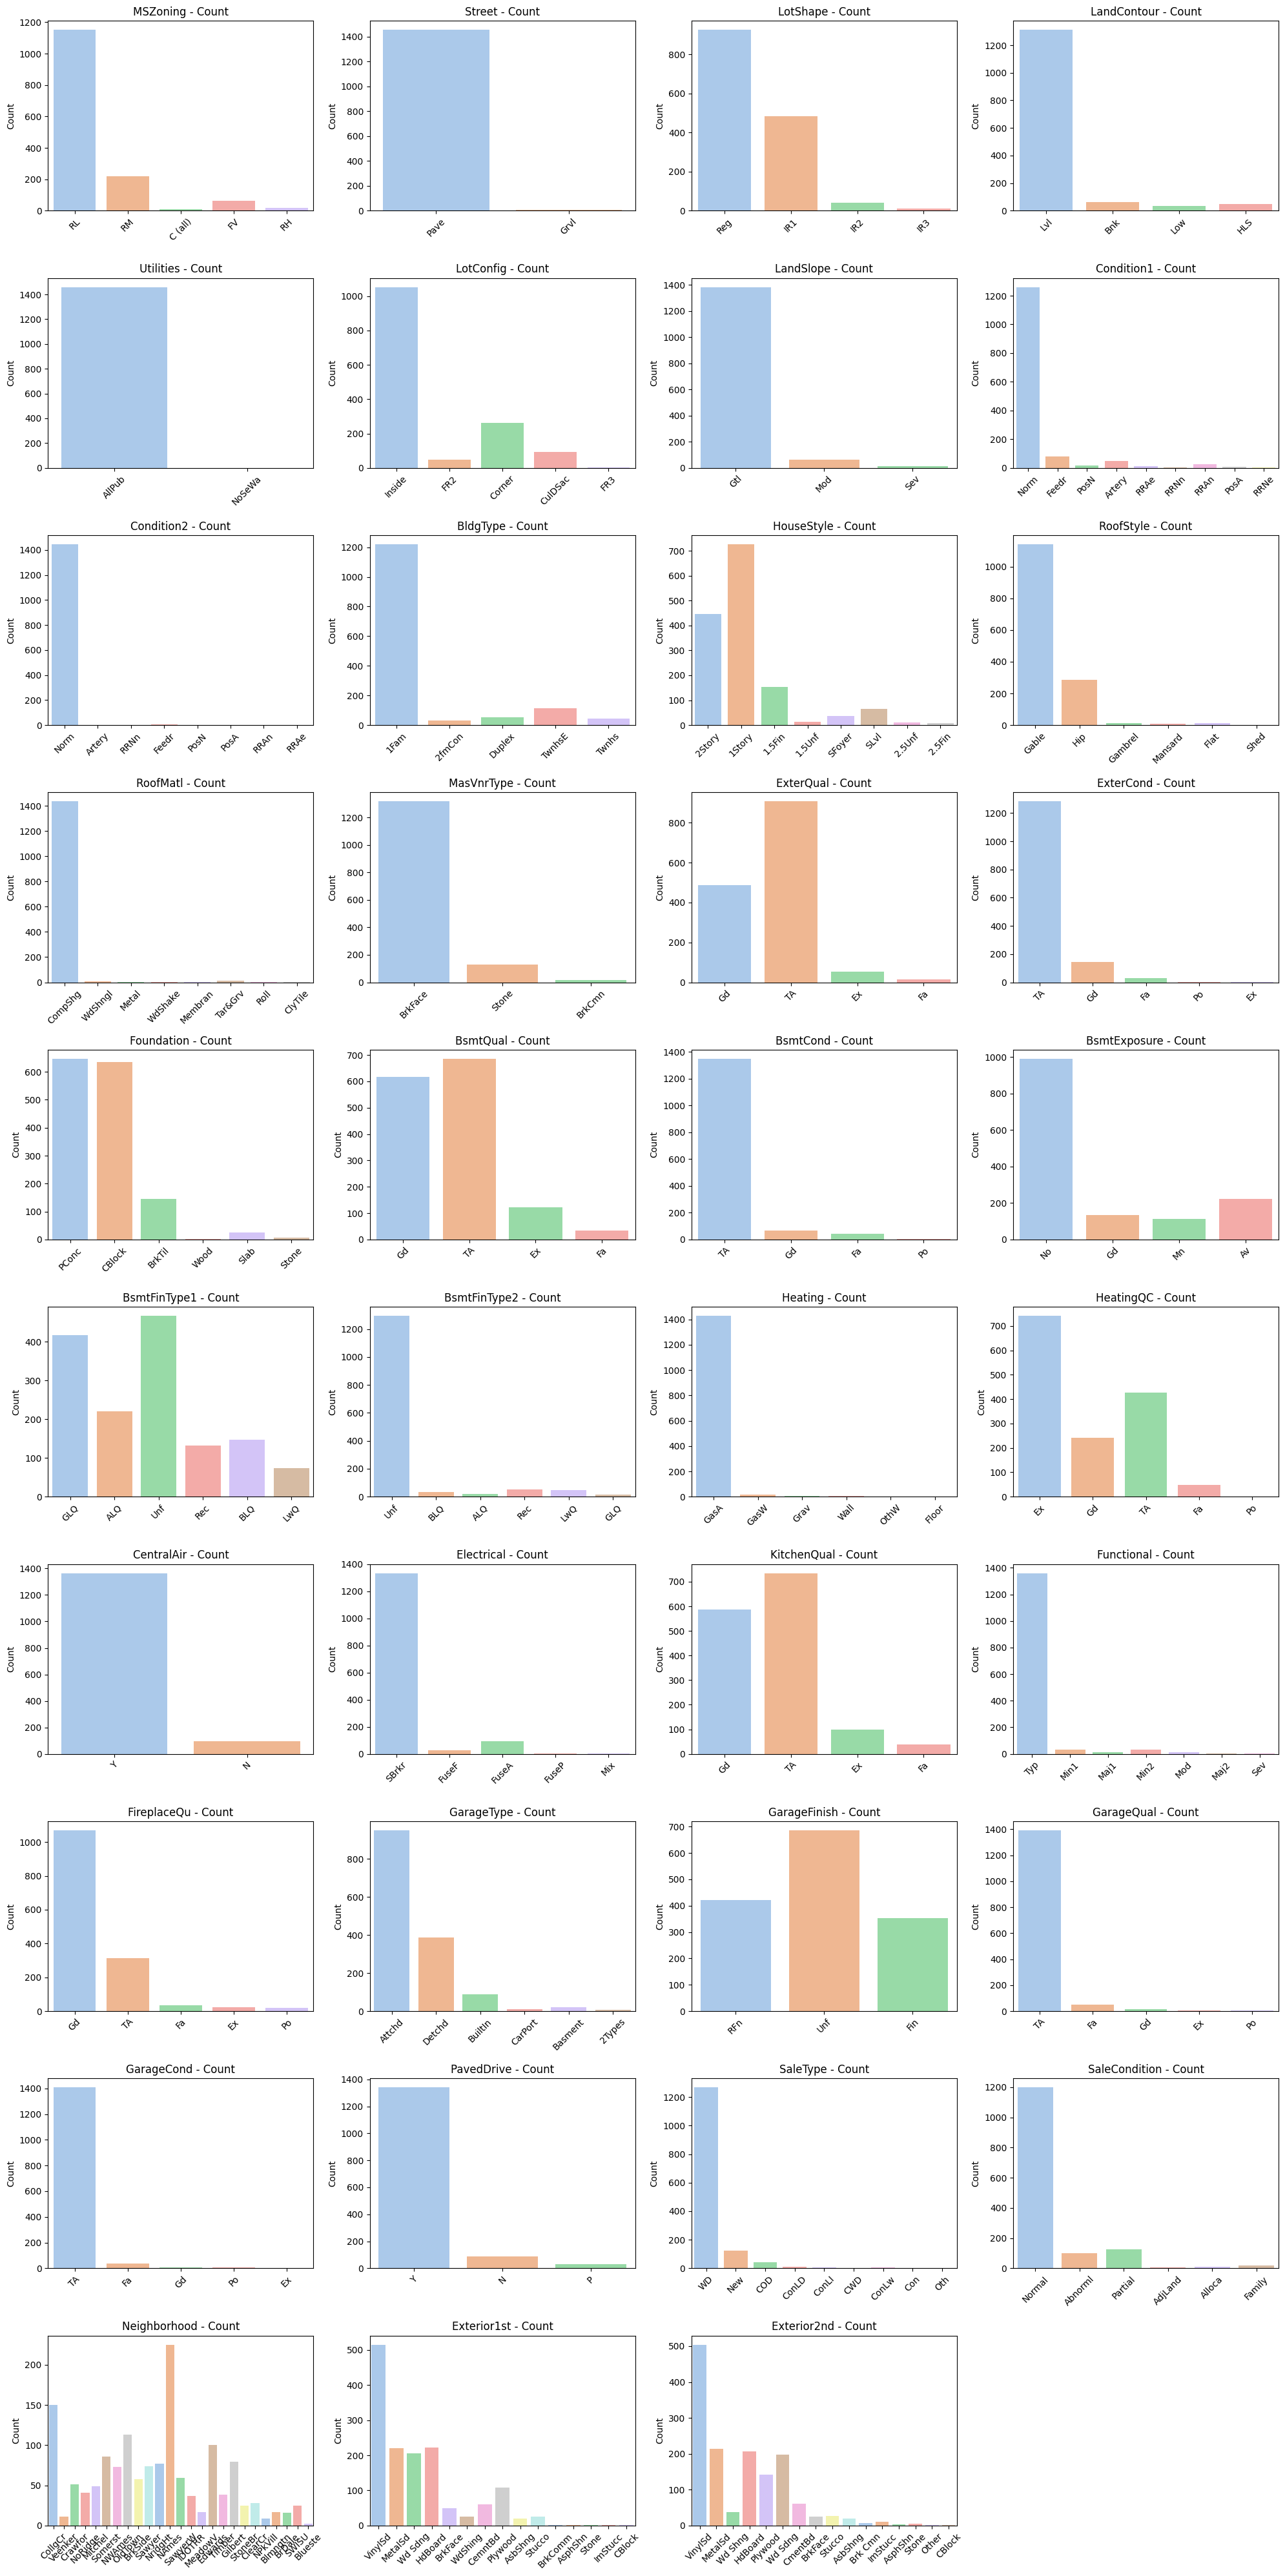

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

n = len(category_columns)

# Determine rows and columns dynamically
n_cols = 4
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(category_columns):
    sns.countplot(x=col, data=df_clean, ax=axes[i], palette='pastel')
    axes[i].set_title(f'{col} - Count')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig("new.png")
plt.show()

**Features that are more evenly distributed have a higher potential to serve as effective predictors.**

The countplots visualize the distribution of values within each categorical feature. Key observations include:

*   **Dominant Categories:** Many features have a single category that appears much more frequently than others (e.g., 'MSZoning' is dominated by 'RL'). These features may have limited predictive power on their own but could be useful when combined with other features.
*   **Diverse Distributions:** Some features, like 'Neighborhood', 'HouseStyle', and exterior related columns, show a more even distribution across their categories. These features are likely to be more informative for predicting `SalePrice`.
*   **Potential Issues:** Some categories have very few instances. These rare categories might need to be grouped with other categories or handled specifically during feature engineering to avoid issues with model training.

Overall, these plots help us understand the composition of our categorical data and identify potential areas for feature engineering or further analysis.

### Target Analysis

<Axes: xlabel='SalePrice', ylabel='Count'>

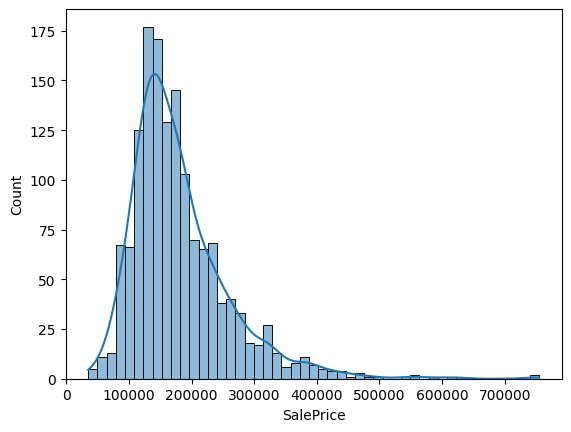

In [33]:
sbn.histplot(df_clean['SalePrice'],kde=True)

**Insights**
- `SalePrice` data points is right skewed
- This violates one of the key assumptions of regression, which may affect the validity of the model.
- Hence, transformations such as Box-Cox or Log Transformation will be applied in the forthcoming stage.

### **Correlation Analysis**

#### Numerical Features

In [34]:
num_features = df_clean.select_dtypes(include=['int64','float64','int32']).columns.to_list()

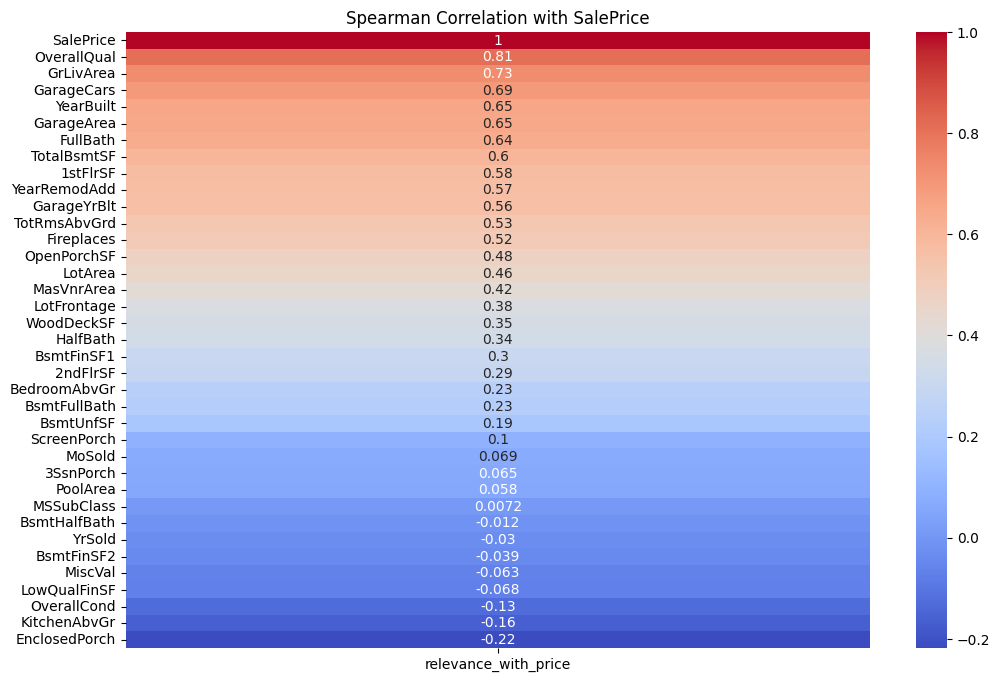

In [35]:
correlation = df_clean[num_features].corr(method='spearman')['SalePrice'].sort_values(ascending=False)
corr_num_df = correlation.to_frame(name="relevance_with_price")
plt.figure(figsize=(12,8))
sns.heatmap(corr_num_df, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation with SalePrice")
plt.show()

In [36]:
relevant_num_features = corr_num_df[(corr_num_df['relevance_with_price'] > 0.7) & (corr_num_df.index != "SalePrice")].index.to_list()
relevant_num_features

['OverallQual', 'GrLivArea']

#### Categorical Features

| Method                 | Feature Type       | Target Type                     | Pros                              | Cons                            |
| ---------------------- | ------------------ | ------------------------------- | --------------------------------- | ------------------------------- |
| ANOVA / F-test         | Categorical        | Numeric                         | Simple, interpretable             | Only significance, not strength |
| Correlation ratio η²   | Categorical        | Numeric                         | Measures explained variance       | Slightly complex                |
| Mutual Information     | Categorical        | Numeric                         | Captures non-linear relationships | Needs encoding, no direction    |
| Point Biserial         | Binary categorical | Numeric                         | Simple correlation                | Only binary categories          |
| Spearman / Kendall     | Ordinal            | Numeric                         | Captures monotonic trends         | Not for nominal                 |
| Tree-based importance  | Any                | Numeric                         | Non-linear, mixed types           | Model-dependent                 |
| Permutation importance | Any                | Numeric                         | Model-agnostic                    | Slower                          |
| Chi-squared            | Categorical        | Categorical (or binned numeric) | Statistical dependence            | Needs target binning            |


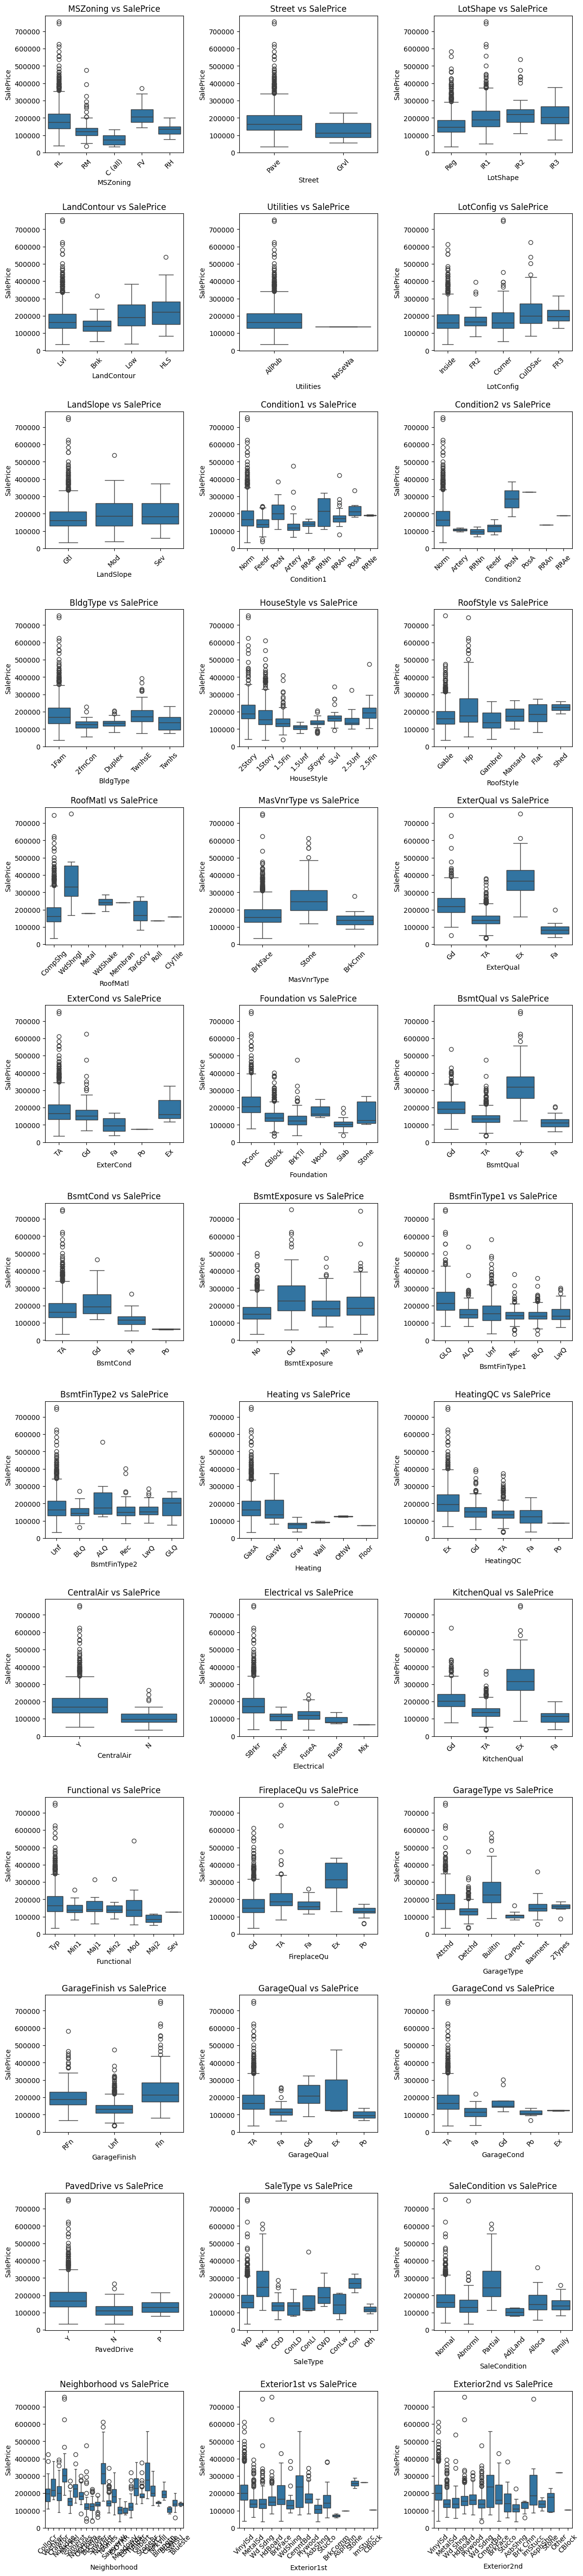

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example categorical features
# Determine number of rows and columns for subplots
n_features = len(category_columns)
n_cols = 2  # number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # ceil division

fig, axes = plt.subplots(n_rows, 3, figsize=(12, n_rows*4))
axes = axes.flatten()  # flatten in case of single row/column

for i, cat in enumerate(category_columns):
    sns.boxplot(x=df_clean[cat], y=df_clean['SalePrice'], ax=axes[i])
    axes[i].set_title(f'{cat} vs SalePrice')
    axes[i].tick_params(axis='x', rotation=45)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

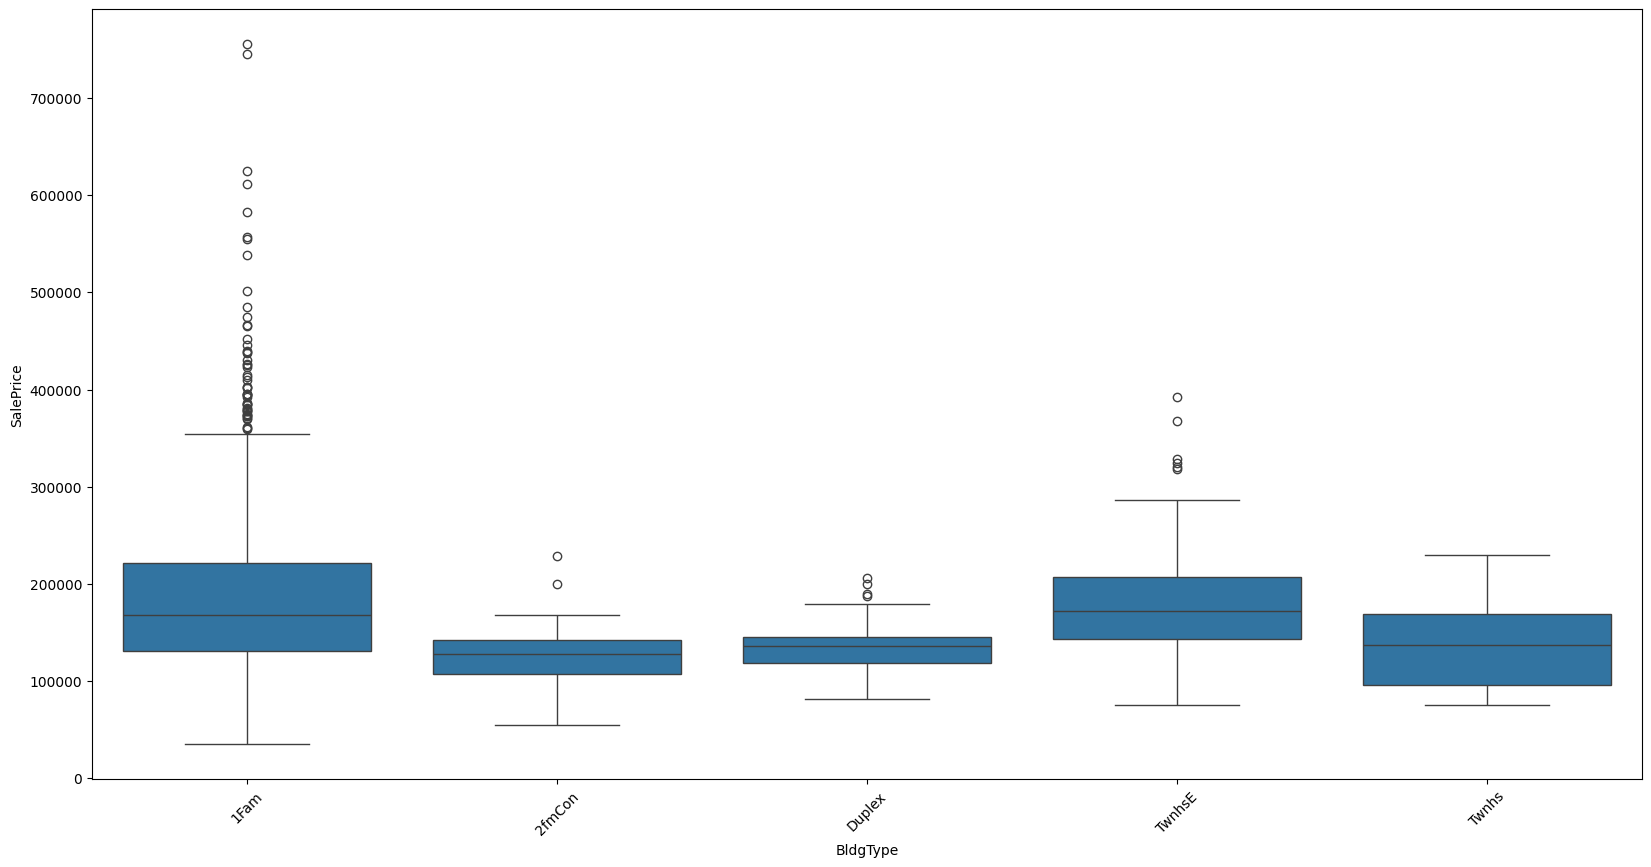

In [38]:
plt.figure(figsize=(20, 10))
sbn.boxplot(x=df_clean['BldgType'],y=df_clean['SalePrice'])
plt.xticks(rotation=45)
plt.show()

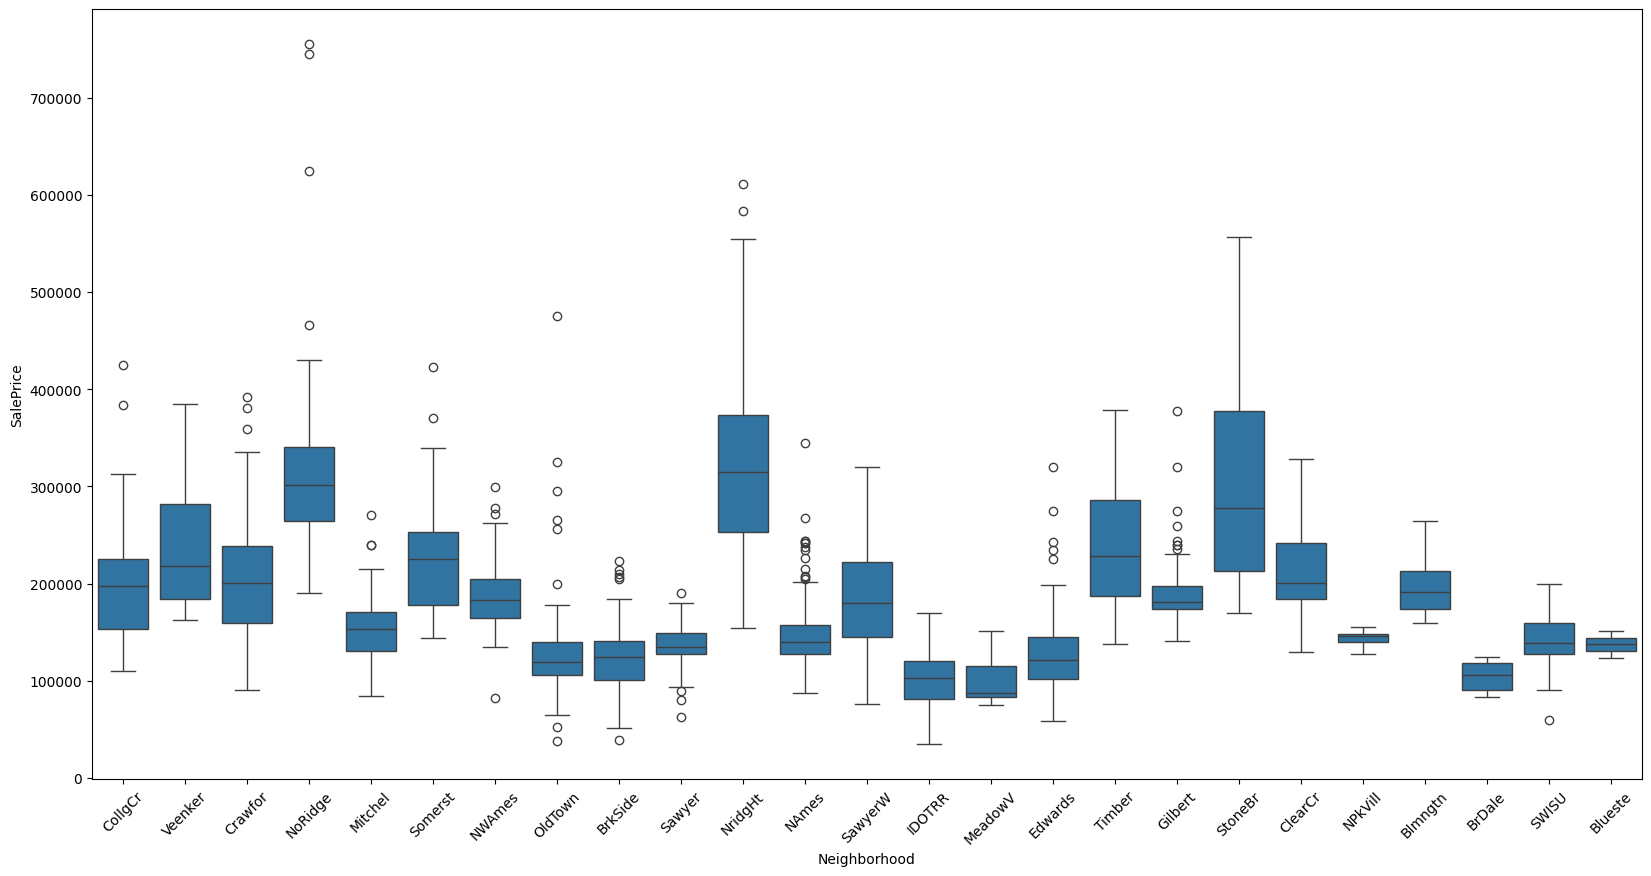

In [39]:
plt.figure(figsize=(20, 10))
sbn.boxplot(x=df_clean['Neighborhood'],y=df_clean['SalePrice'])
plt.xticks(rotation=45)
plt.show()

| Method | Type of Categorical Variable | Type of Numeric Variable | When to Use |
|---------------------------|-----------------------------|-------------------------|--------------------------------------|
| Point Biserial Correlation | Binary | Continuous | Two categories |
| ANOVA | Nominal | Continuous | More than two categories |
| Kruskal-Wallis H Test | Nominal | Continuous | Non-parametric, more than two categories |
| Chi-Squared Test | Nominal | Categorical (binned) | Relationship between two categorical variables |
| Spearman's Rank Correlation| Ordinal | Continuous | Ordered categories |

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import f_oneway


class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Combines numeric and categorical correlation analysis for regression.

    Parameters
    ----------
    target : str
        Name of the target column.
    eta_threshold : float, default=0.25
        Minimum correlation ratio (eta squared) to select categorical features.
    pvalue_threshold : float, default=0.05
        ANOVA p-value threshold to select categorical features.
    visualize : bool, default=False
        If True, plots numeric and categorical correlations.
    """

    def __init__(
        self,
        target=None,
        num_feat_corr_threshold=0.7,
        eta_threshold=0.25,
        pvalue_threshold=0.05,
        visualize=False,
        chosen_features=[]
    ):
        self.target = target
        self.eta_threshold = eta_threshold
        self.num_feat_corr_threshold = num_feat_corr_threshold
        self.pvalue_threshold = pvalue_threshold
        self.visualize = visualize
        self.selected_features_ = []
        self.chosen_features = chosen_features
        self.num_corr_df_ = None
        self.cat_corr_df_ = None

    @staticmethod
    def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        mean_total = measurements.mean()
        ss_between = sum(
            len(measurements[fcat == i])
            * (measurements[fcat == i].mean() - mean_total) ** 2
            for i in np.unique(fcat)
        )
        ss_total = sum((measurements - mean_total) ** 2)
        return ss_between / ss_total if ss_total != 0 else 0

    def fit(self, X, y=None):
        # Numeric correlation
        if self.chosen_features:
            return self
        self.num_corr_df_ = (
            X.corr(method="spearman", numeric_only=True)[self.target]
            .sort_values(ascending=False)
            .to_frame(name=f"Correlation with {self.target}")
        )

        # Extract correlation values as Series for feature selection
        corr_series = X.corr(method="spearman", numeric_only=True)[self.target]
        self.selected_features_ = corr_series[
            (corr_series.abs() > self.num_feat_corr_threshold)
            & (corr_series.index != self.target)
        ].index.tolist()

        # Categorical correlation
        results = []
        cat_cols = X.select_dtypes(include="object").columns.tolist()
        for col in cat_cols:
            groups = [X[self.target][X[col] == lvl] for lvl in X[col].dropna().unique()]
            if len(groups) < 2:
                continue
            f_stat, p_val = f_oneway(*groups)
            eta = self.correlation_ratio(X[col], X[self.target])
            results.append(
                {
                    "Feature": col,
                    "F_stat": f_stat,
                    "p_value": p_val,
                    "Correlation_Ratio": eta,
                }
            )

        df_results = pd.DataFrame(results)
        self.cat_corr_df_ = df_results.sort_values("Correlation_Ratio", ascending=False)

        # Feature selection
        if not df_results.empty:
            mask = (df_results["Correlation_Ratio"] > self.eta_threshold) & (
                df_results["p_value"] < self.pvalue_threshold
            )
            filtered = df_results[mask]
            self.selected_features_.extend(filtered["Feature"].tolist())

        if self.visualize:
            self.plot()

        return self

    def transform(self, X):
        if not self.selected_features_ and not self.chosen_features:
            return X
        if self.chosen_features:
          return X[self.chosen_features]
        else:
          cols_to_keep = self.selected_features_

        return X[cols_to_keep+[self.target]]

    def plot(self):

        # Numeric
        plt.figure(figsize=(15, 8))
        plt.subplot(121)
        sns.heatmap(self.num_corr_df_, annot=True, cmap="coolwarm")
        plt.title(f"Numeric Correlation with {self.target}")

        # Categorical
        plt.subplot(122)
        if not self.cat_corr_df_.empty:
            sns.barplot(
                x="Correlation_Ratio",
                y="Feature",
                data=self.cat_corr_df_,
                palette="viridis",
            )
            plt.title(f"Categorical Correlation with {self.target}")
            plt.xlabel("Correlation Ratio (η²)")
            plt.ylabel("Categorical Feature")
        plt.tight_layout()
        plt.show()


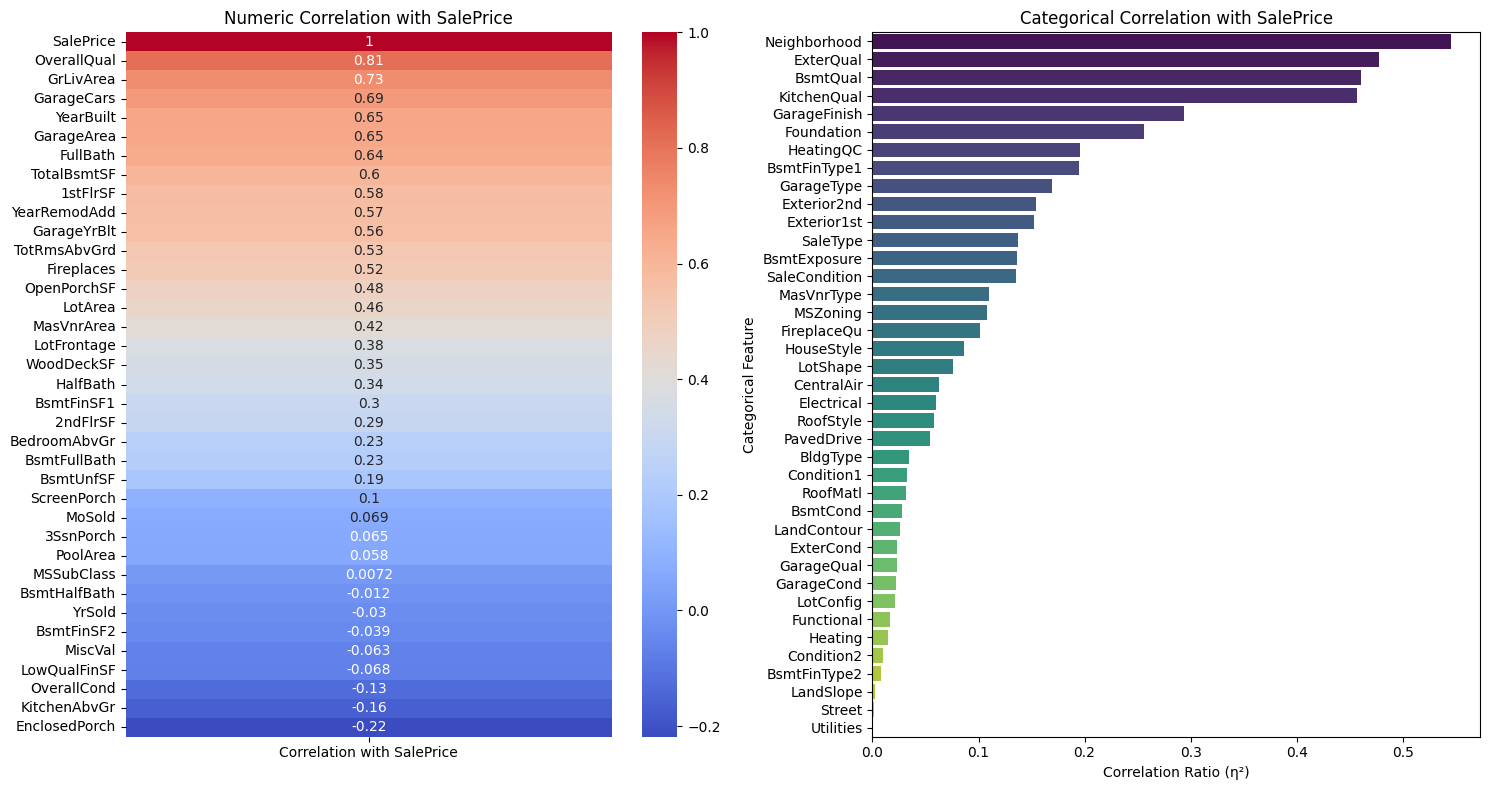

OverallQual  GrLivArea ExterQual Foundation BsmtQual KitchenQual  \
0               7       1710        Gd      PConc       Gd          Gd   
1               6       1262        TA     CBlock       Gd          TA   
2               7       1786        Gd      PConc       Gd          Gd   
3               7       1717        TA     BrkTil       TA          Gd   
4               8       2198        Gd      PConc       Gd          Gd   
...           ...        ...       ...        ...      ...         ...   
1455            6       1647        TA      PConc       Gd          TA   
1456            6       2073        TA     CBlock       Gd          TA   
1457            7       2340        Ex      Stone       TA          Gd   
1458            5       1078        TA     CBlock       TA          Gd   
1459            5       1256        Gd     CBlock       TA          TA   

     GarageFinish Neighborhood  SalePrice  
0             RFn      CollgCr     208500  
1             RFn      Veenker     181500  
2             RFn      CollgCr     223500  
3             Unf      Crawfor     140000  
4             RFn      NoRidge     250000  
...           ...          ...        ...  
1455          RFn      Gilbert     175000  
1456          Unf       NWAmes     210000  
1457          RFn      Crawfor     266500  
1458          Unf        NAmes     142125  
1459          Fin      Edwards     147500  

[1460 rows x 9 columns]

In [41]:
feature_selector = FeatureSelector(visualize=True,target="SalePrice")
feature_selector.fit_transform(df_clean)

In [42]:
df_feat_extracted = pd.concat([df_clean[feature_selector.selected_features_],df_clean["SalePrice"]],axis=1)

In [43]:
df_feat_extracted.isnull().sum()

OverallQual     0
GrLivArea       0
ExterQual       0
Foundation      0
BsmtQual        0
KitchenQual     0
GarageFinish    0
Neighborhood    0
SalePrice       0
dtype: int64

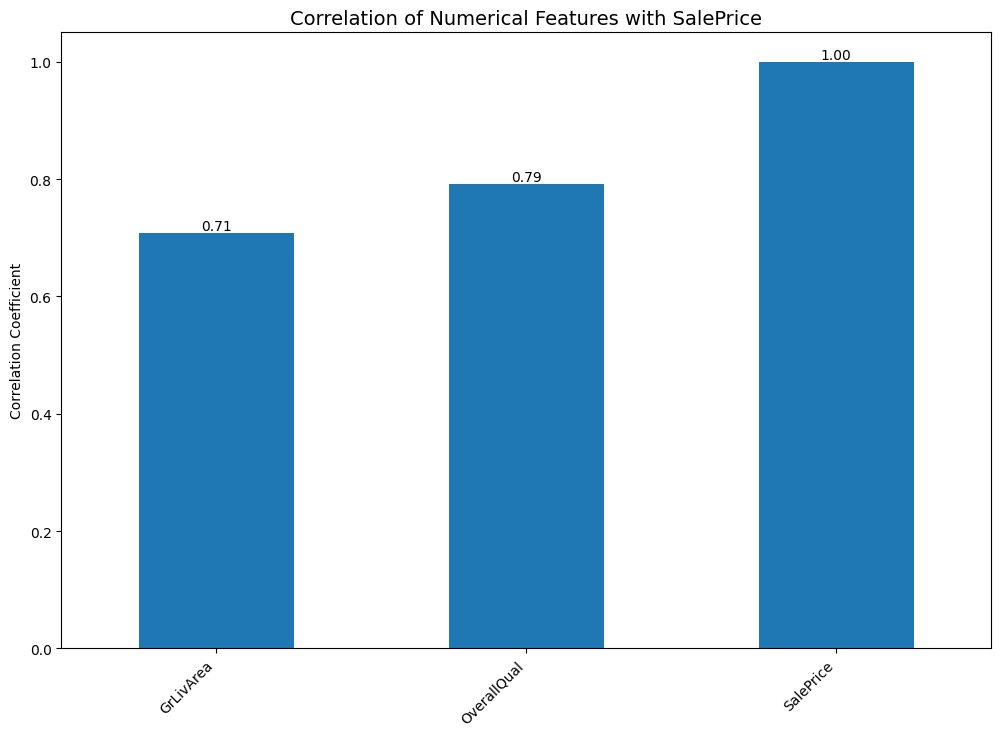

In [44]:

corr = df_feat_extracted.corr(numeric_only=True)['SalePrice'].sort_values()

# Plot as bar chart
ax = corr.plot(kind='bar', figsize=(12, 8))

# Annotate bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

plt.title("Correlation of Numerical Features with SalePrice", fontsize=14)
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.show()

### Feature Explanation

### 🏘️ Neighborhood

* **Type**: Categorical
* **Description**: Physical locations within Ames city limits.
* **Examples**:

  * `Blmngtn` → Bloomington Heights
  * `Gilbert` → Gilbert
  * `StoneBr` → Stone Brook

---

### 🪟 ExterQual

* **Type**: Ordinal (categorical with order)
* **Description**: Evaluates the quality of the material on the exterior.
* **Values**:

  * `Ex` → Excellent
  * `Gd` → Good
  * `TA` → Typical/Average
  * `Fa` → Fair
  * `Po` → Poor

---

### 🏠 BsmtQual

* **Type**: Ordinal
* **Description**: Evaluates the height of the basement.
* **Values**:

  * `Ex` → Excellent (100+ inches)
  * `Gd` → Good (90–99 inches)
  * `TA` → Typical (80–89 inches)
  * `Fa` → Fair (70–79 inches)
  * `Po` → Poor (<70 inches)
  * `NA` → No Basement

---

### 👩‍🍳 KitchenQual

* **Type**: Ordinal
* **Description**: Kitchen quality rating.
* **Values**:

  * `Ex` → Excellent
  * `Gd` → Good
  * `TA` → Typical/Average
  * `Fa` → Fair
  * `Po` → Poor

---

### 🚗 GarageFinish

* **Type**: Categorical
* **Description**: Interior finish of the garage.
* **Values**:

  * `Fin` → Finished
  * `RFn` → Rough Finished
  * `Unf` → Unfinished
  * `NA` → No Garage

---

### 🧱 Foundation

* **Type**: Categorical
* **Description**: Type of foundation of the house.
* **Values**:

  * `BrkTil` → Brick & Tile
  * `CBlock` → Cinder Block
  * `PConc` → Poured Concrete
  * `Slab` → Slab
  * `Stone` → Stone
  * `Wood` → Wood

---

### 📊 OverallQual

* **Type**: Ordinal (1–10 scale)
* **Description**: Rates the overall material and finish of the house.
* **Scale**:

  * `10` → Very Excellent
  * `9` → Excellent
  * `8` → Very Good
  * `7` → Good
  * `6` → Above Average
  * `5` → Average
  * `4` → Below Average
  * `3` → Fair
  * `2` → Poor
  * `1` → Very Poor

---

### 📏 GrLivArea

* **Type**: Numerical (continuous)
* **Description**: Above grade (ground) living area square feet.
* **Example**: `1500` sq. ft., `2500` sq. ft.

---

### 💰 SalePrice

* **Type**: Numerical (continuous, target variable)
* **Description**: Sale price of the house in USD.
* **Example**: `200000`, `340000`

---


### **Bivariate Analysis**

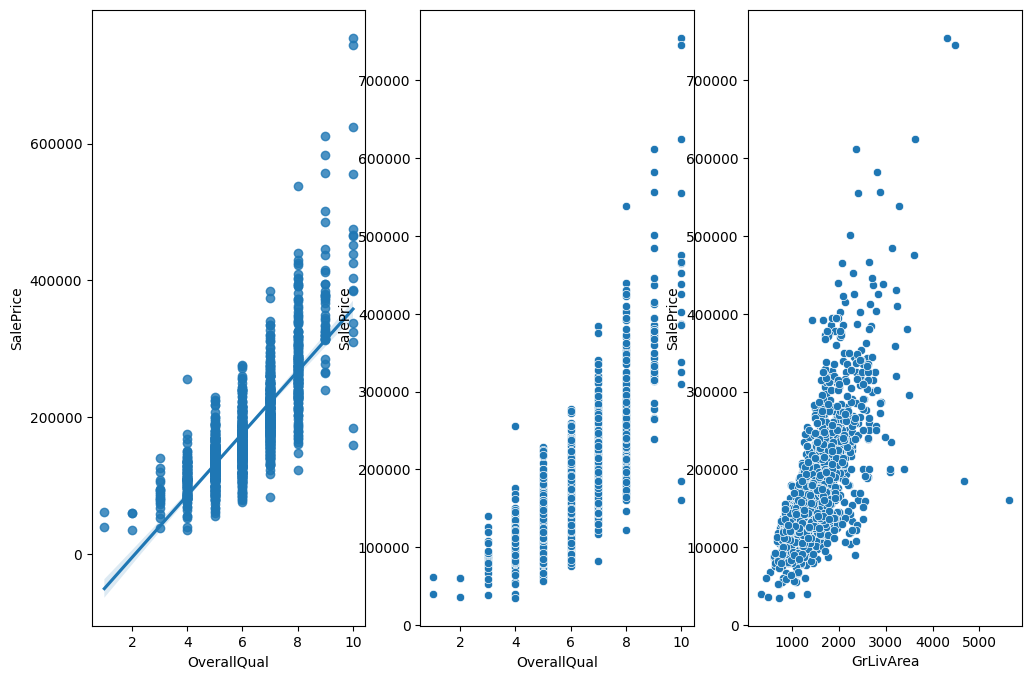

In [45]:
plt.figure(figsize=(12, 8))
# sns.scatterplot(x='OverallQual', y='SalePrice', data=df_clean)
plt.subplot(1, 3, 1)
sns.regplot(x='OverallQual', y='SalePrice', data=df_feat_extracted)
plt.subplot(1, 3, 2)
sns.scatterplot(x='OverallQual', y='SalePrice', data=df_feat_extracted)
# plt.show()
plt.subplot(1, 3, 3)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_feat_extracted)
plt.show()

**Above plot depicts strong relationshsip between OverQual and SalePrice**

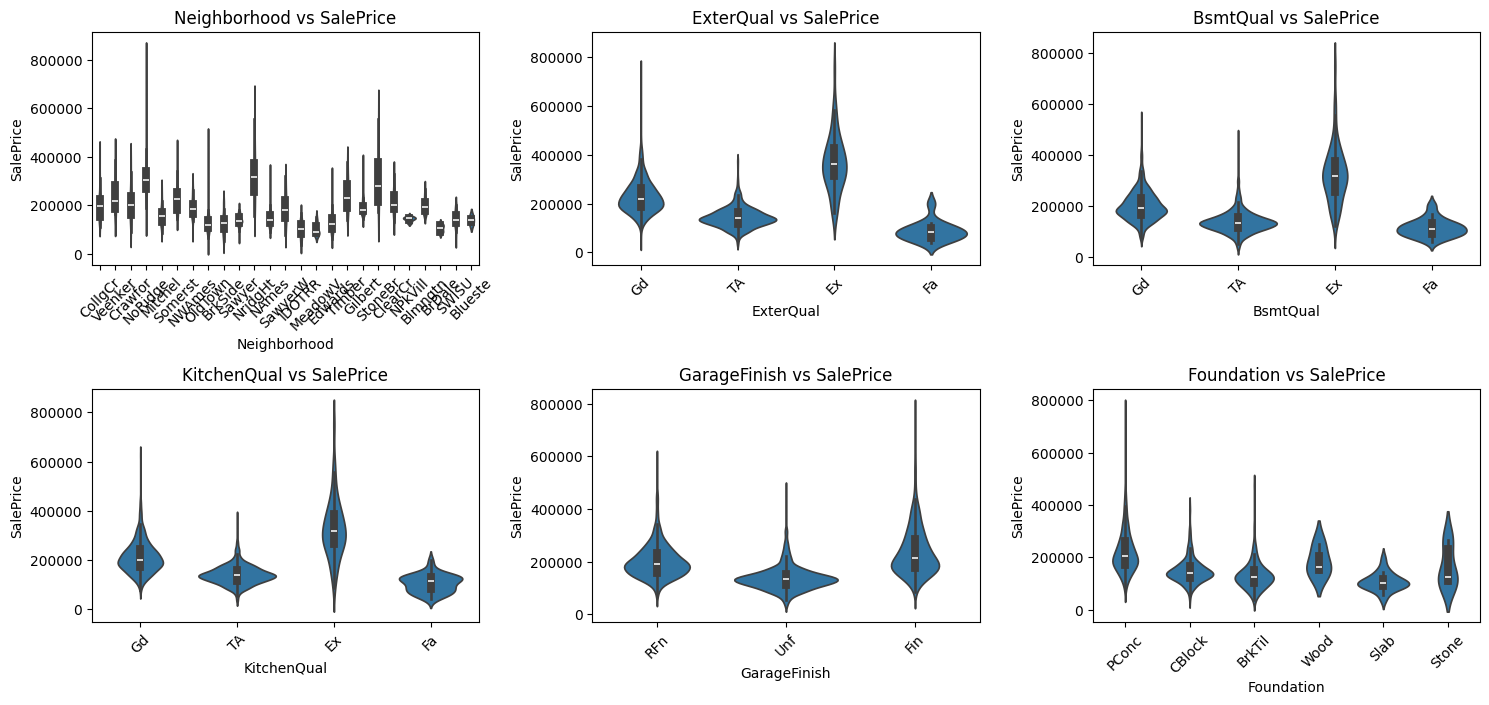

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ["Neighborhood","ExterQual","BsmtQual","KitchenQual","GarageFinish","Foundation"]

# Define subplot grid
n_cols = 3
n_rows = (len(categorical_cols) +1) // n_cols
fig, axes = plt.subplots(n_rows+1, n_cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easy indexing

for i, col in enumerate(categorical_cols):
    sns.violinplot(x=col, y="SalePrice", data=df_feat_extracted, ax=axes[i])
    axes[i].set_title(f"{col} vs SalePrice")
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Multivariate Analysis

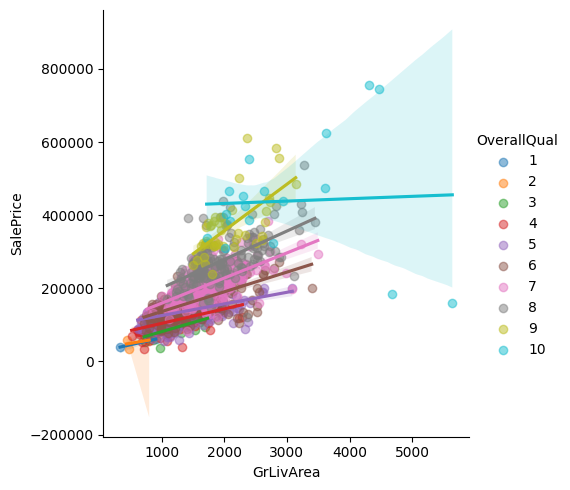

In [47]:
sns.lmplot(
    data=df_feat_extracted,
    x="GrLivArea", y="SalePrice",
    hue="OverallQual", scatter_kws={"alpha":0.5}
)
plt.show()


- There is a general positive correlation between living area and sales price, meaning larger homes tend to have higher sales prices.
- Homes with higher OverallQual ratings (e.g., 8, 9, 10) are mostly clustered at higher sales prices and larger living areas, indicating better quality homes are more expensive.
- Lower-rated homes (e.g., 1, 2, 3) are concentrated at lower sales prices and smaller living areas.
- A cyan triangular confidence interval suggests a trend line, with most data points falling within or near this area, reinforcing the correlation.
- Outliers exist, such as a few homes with large living areas but relatively low sales prices, possibly indicating other influencing factors like location or condition.

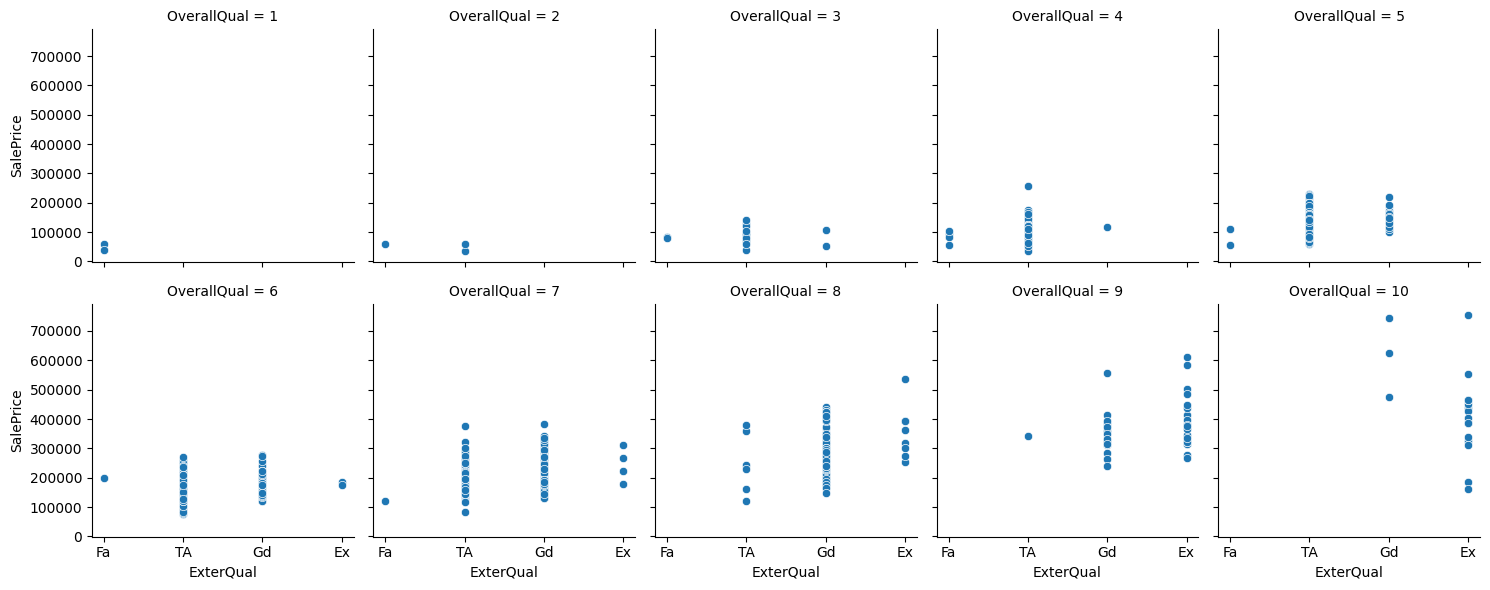

In [48]:
g = sns.FacetGrid(df_feat_extracted, col="OverallQual", col_wrap=5, height=3)
g.map(sns.scatterplot, "ExterQual", "SalePrice")
plt.show()


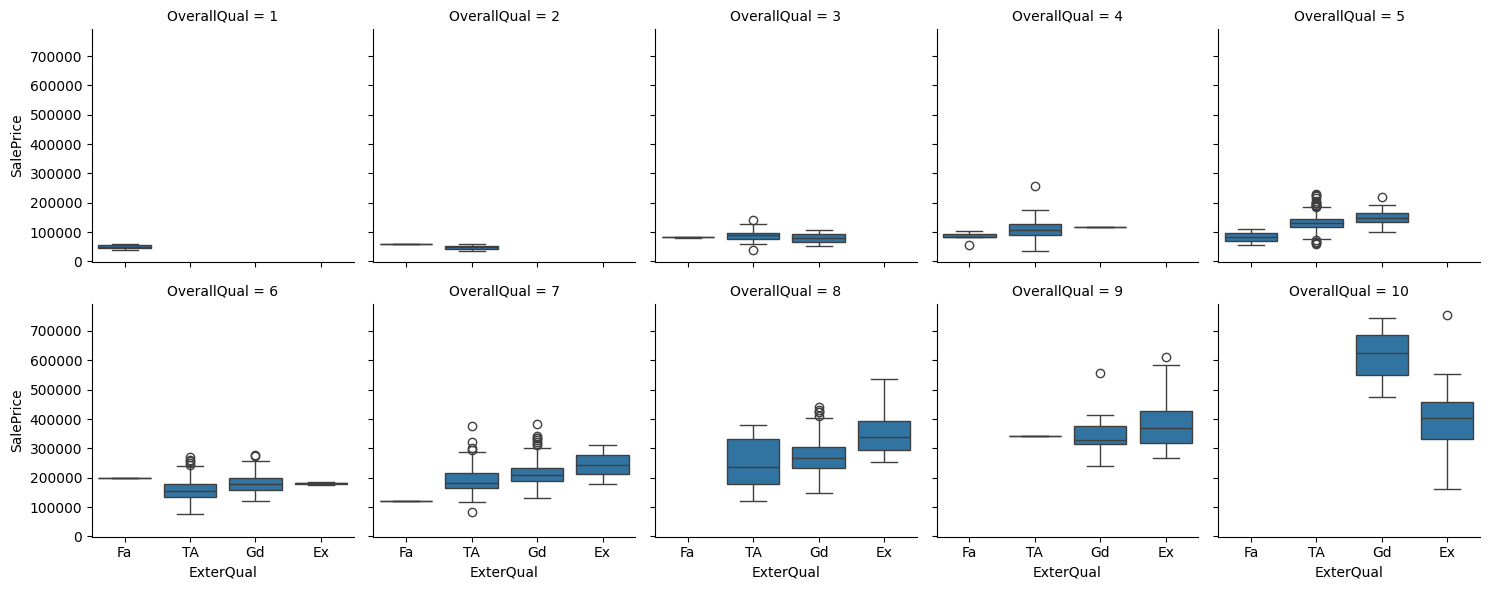

In [49]:
g = sns.FacetGrid(df_feat_extracted, col="OverallQual", col_wrap=5, height=3)
g.map(sns.boxplot, "ExterQual", "SalePrice")
plt.show()


- **OverallQual Impact**: Sales prices generally increase with higher OverallQual ratings. Homes with OverallQual 1-3 have very low median prices \(below \$100,000\)  while those with OverallQual $8-10$ show median prices ranging from \$200,000 to over \$400,000.

- **ExterQual Influence**: Within each OverallQual category, exterior quality (Fa to Ex) shows a trend where better exterior quality (Gd, Ex) tends to correlate with higher sales prices, though the effect is more pronounced in higher OverallQual groups (e.g., 8-10).
- **Variability**: Lower OverallQual ratings (1-5) show less variability and lower price ranges, while higher ratings (6-10) exhibit greater spread, with some homes reaching up to $600,000-$700,000, especially with excellent exterior quality.
- **Outliers**: Notable outliers exist, particularly in OverallQual 5-10, where some homes exceed $500,000, suggesting exceptional cases influenced by factors beyond quality ratings.

This indicates that both overall quality and exterior quality significantly affect sales prices, with stronger effects at higher quality levels.

**ExterQual is associated with OverallQual rather than causing it. To decide whether both should be kept in the regression model, we need to check multicollinearity using VIF**

In [50]:
df_feat_extracted['Foundation'].value_counts()

Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64

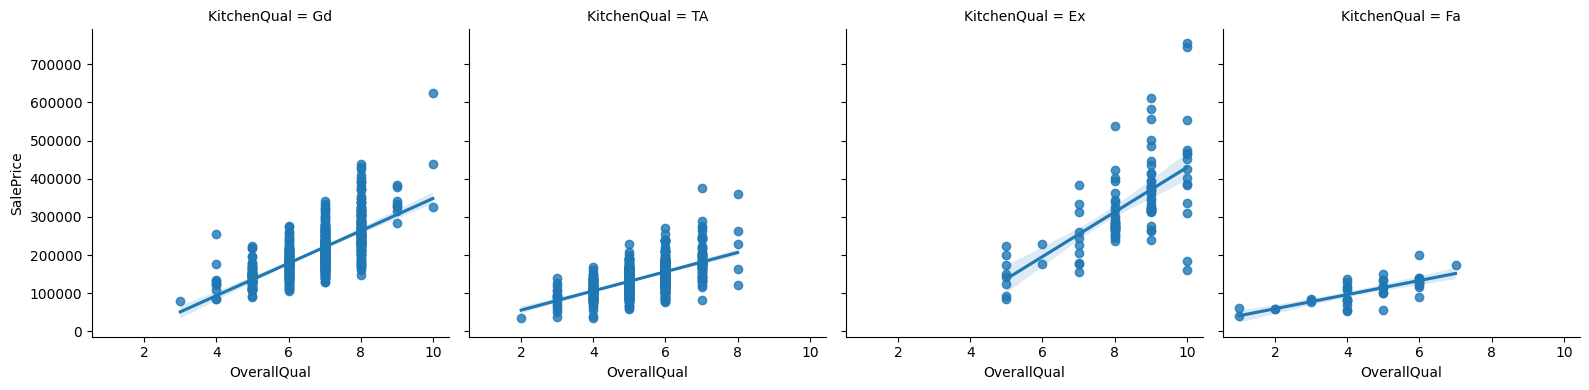

In [51]:
g = sbn.FacetGrid(df_feat_extracted, col="KitchenQual", col_wrap=4, height=4)
g.map(sbn.regplot, "OverallQual", "SalePrice")
plt.show()

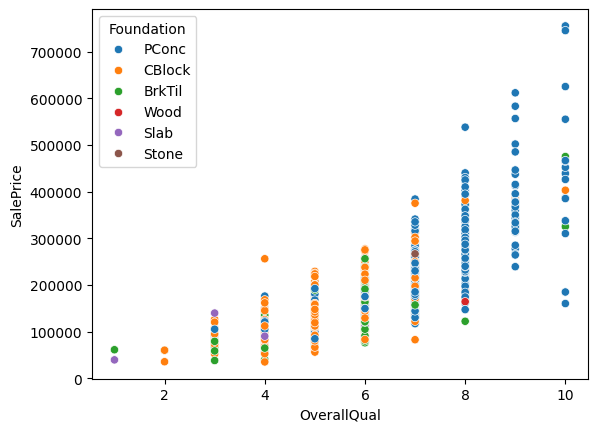

In [52]:
sbn.scatterplot(data=df_feat_extracted, x="OverallQual", y="SalePrice", hue="Foundation")
plt.show()

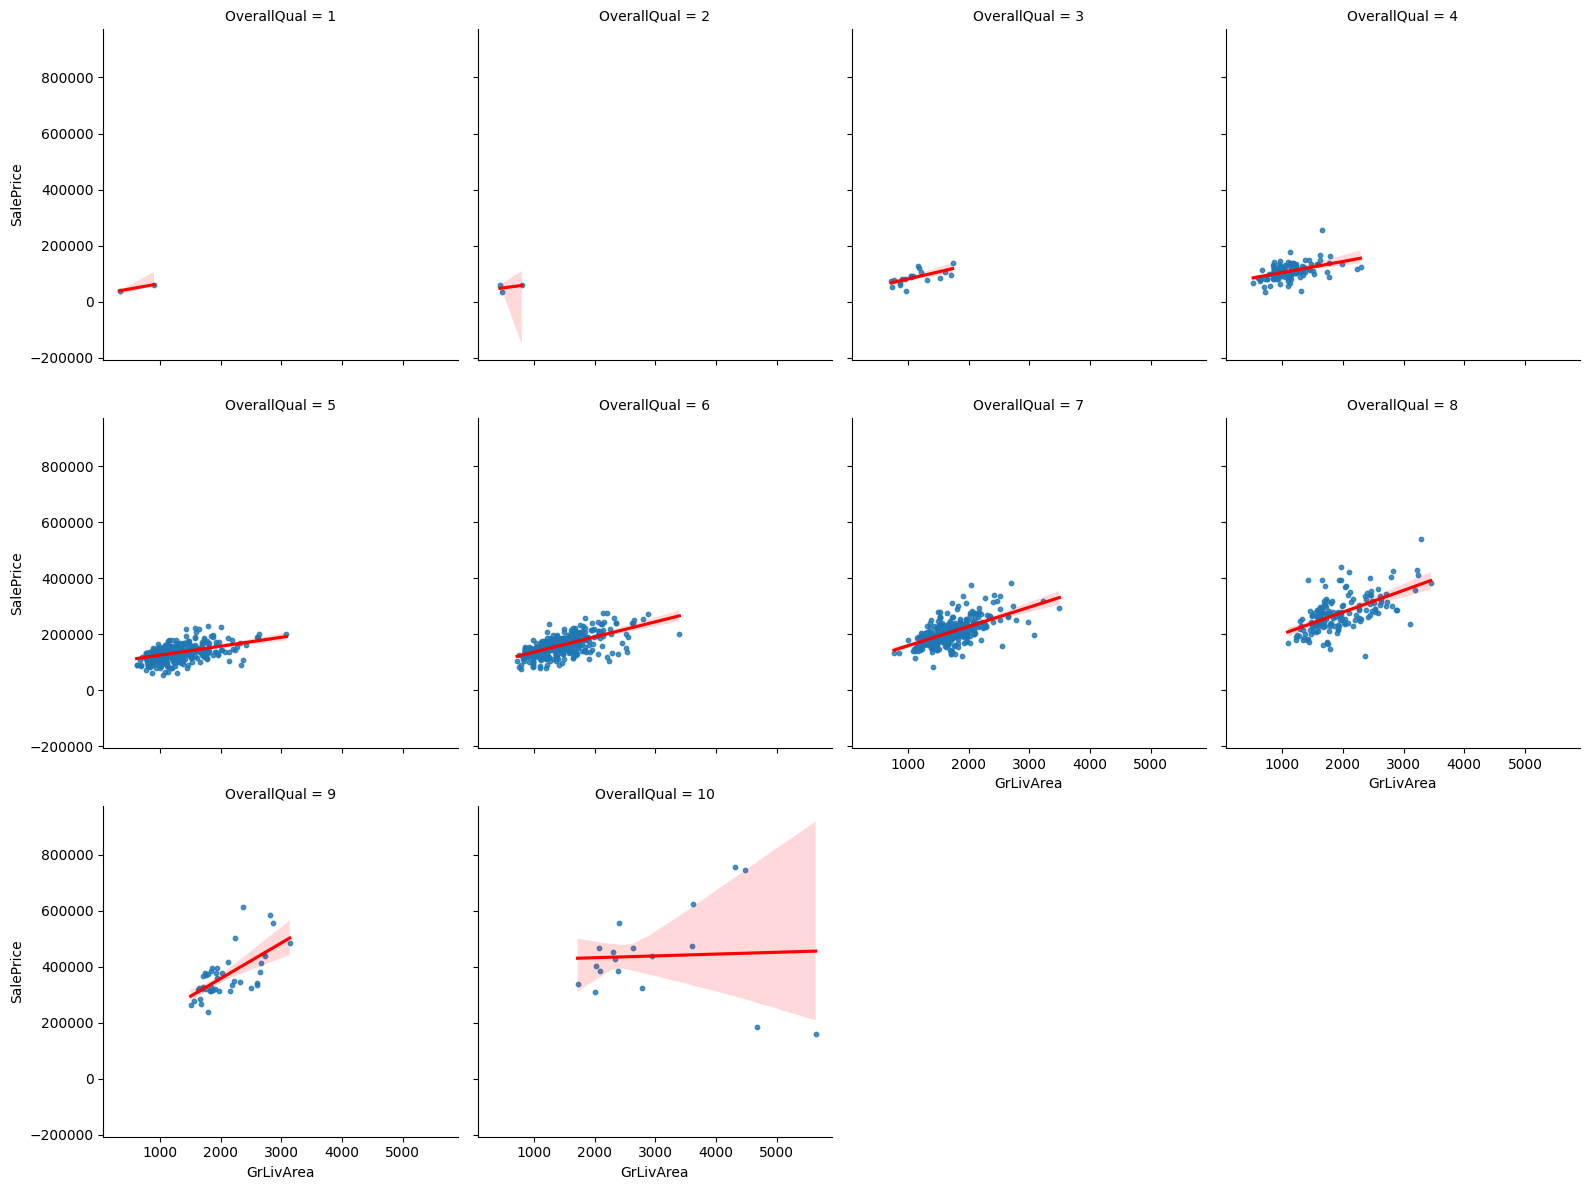

In [53]:
g = sbn.FacetGrid(df_feat_extracted, col="OverallQual", col_wrap=4, height=4)
g.map(sns.regplot, "GrLivArea", "SalePrice", scatter_kws={'s':10}, line_kws={'color':'red'})
plt.show()

The **light red space around the regression line** is the **confidence interval (CI)** of the regression estimate.

* By default, `sns.regplot` shows a **95% confidence interval**.
* It represents the range in which the true regression line is likely to fall.
* Narrow bands → more certainty in the regression estimate.
* Wider bands → more variability or fewer data points.


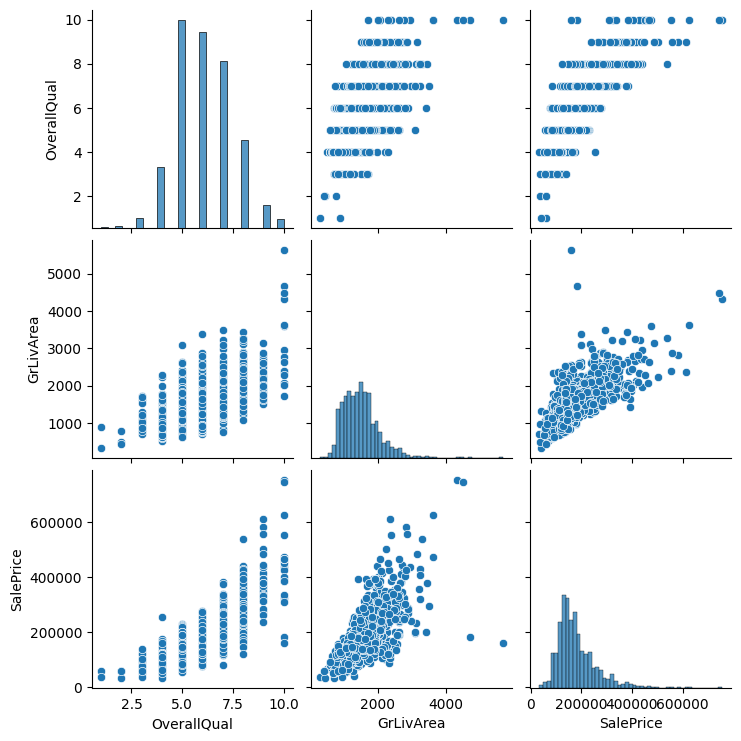

In [54]:
sns.pairplot(df_feat_extracted[['OverallQual', 'GrLivArea', 'SalePrice']])
plt.show()

### Feature Encoding

In [55]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


# -----------------------------
# 1) Feature Groups
# -----------------------------
# ordinal_features = ["ExterQual", "BsmtQual", "KitchenQual"]
# categorical_features = ["Neighborhood", "GarageFinish", "Foundation"]
# numerical_features = ["OverallQual", "GrLivArea"]

# ordinal_mappings = {
#     "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
#     "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
#     "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
# }


# -----------------------------
# 5) Decode Helper (works with both Pipeline and make_pipeline)
# -----------------------------
def decode(pipeline, encoder_step, feature, encoded_value):
    """
    Recover original category from encoded integer.
    Works with both Pipeline and make_pipeline.

    For make_pipeline, step names are auto-generated like:
    - 'ordinalmapper' (lowercase, no underscores)
    - 'categoricallabelencoder'
    """
    # Handle both named steps (Pipeline) and auto-generated names (make_pipeline)
    if hasattr(pipeline, "named_steps"):
        # For Pipeline with named steps
        if encoder_step in pipeline.named_steps:
            encoders = pipeline.named_steps[encoder_step].encoders
        else:
            # For make_pipeline, try auto-generated names
            step_names = list(pipeline.named_steps.keys())
            print(f"Available steps: {step_names}")
            raise ValueError(
                f"Step '{encoder_step}' not found. Available steps: {step_names}"
            )
    else:
        # For very old sklearn versions or custom pipelines
        encoders = pipeline.steps[encoder_step][1].encoders

    if feature not in encoders:
        raise ValueError(f"Feature '{feature}' not found in encoders.")

    le = encoders[feature]
    if encoded_value < 0 or encoded_value >= len(le.classes_):
        raise ValueError(f"Encoded value {encoded_value} out-of-range for '{feature}'.")

    return le.inverse_transform([encoded_value])[0]


def decode_make_pipeline(pipeline, feature, encoded_value):
    """
    Simplified decode function specifically for make_pipeline.
    Automatically finds the CategoricalLabelEncoder step.
    """
    # Find the CategoricalLabelEncoder step
    encoder_step = None
    for step_name, step_obj in pipeline.named_steps.items():
        if isinstance(step_obj, CategoricalLabelEncoder):
            encoder_step = step_obj
            break

    if encoder_step is None:
        raise ValueError("CategoricalLabelEncoder not found in pipeline")

    if feature not in encoder_step.encoders:
        raise ValueError(f"Feature '{feature}' not found in encoders.")

    le = encoder_step.encoders[feature]
    if encoded_value < 0 or encoded_value >= len(le.classes_):
        raise ValueError(f"Encoded value {encoded_value} out-of-range for '{feature}'.")

    return le.inverse_transform([encoded_value])[0]


class OrdinalEncoderDF(BaseEstimator, TransformerMixin):
    def __init__(self, cols, categories):
        self.cols = cols
        self.categories = categories
        self.encoder = OrdinalEncoder(categories=self.categories)

    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self

    def transform(self, X):
        X_new = X.copy()
        print(self.encoder.transform(X[self.cols]))
        X_new[self.cols] = self.encoder.transform(X[self.cols])
        X_new[self.cols] = X_new[self.cols].astype(int)
        return X_new


class FrequencyEncoderDF(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        self.cols_ = self.cols or X.select_dtypes(include="object").columns.tolist()
        for col in self.cols_:
            self.freq_maps_[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_new = X.copy()
        for col in self.cols_:
            X_new[col + "_freq"] = X_new[col].map(self.freq_maps_[col]).fillna(0)
        return X_new


# -------------------------
# 2. OneHot Encoder Wrapper
# -------------------------
class OneHotEncoderDF(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = OneHotEncoder(drop="first",handle_unknown="ignore", sparse_output=False)
        self.feature_names_ = []

    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        self.feature_names_ = self.encoder.get_feature_names_out(self.cols)
        return self

    def transform(self, X):
        X_new = X.copy()

        # Transform and get dense array
        data = self.encoder.transform(X_new[self.cols])

        # Debug information
        print(f"++++++++++++++++++++++++++++++++  {self.__class__.__name__} =================================")
        print(f"Transformed data shape: {data.shape}")
        print(f"Feature names: {self.feature_names_}")
        print(f"Number of feature names: {len(self.feature_names_)}")

        # Create DataFrame with encoded features
        encoded = pd.DataFrame(
            data,
            columns=self.feature_names_,
            index=X_new.index,
        )

        # Remove original columns and add encoded ones
        X_new = X_new.drop(columns=self.cols)
        X_new = pd.concat([X_new, encoded.apply(round).astype("int")], axis=1)

        return X_new


# -------------------------
# 3. Target Encoder Wrapper
# -------------------------
class DataFrameTargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder for regression. Compatible with sklearn pipelines.
    Accepts X (DataFrame) and y (Series) in fit, returns DataFrame in transform.
    """

    def __init__(self, cols=None, target=None, smoothing=10):
        self.cols = cols
        self.smoothing = smoothing
        self.target = target
        self.mapping_ = {}
        self.global_mean_ = None

    def fit(self, X):
        self.cols_ = self.cols or X.select_dtypes(include="object").columns.tolist()
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame.")
        if self.target is None:
            raise ValueError("y must be provided.")
        # if self.use_mapping:

        if self.target in X.columns:
            y = X[self.target]
        else:
            return self

        self.global_mean_ = y.mean()

        for col in self.cols_:
            stats = X.groupby(col).size().to_frame("count")
            means = X.groupby(col).apply(lambda df: y[df.index].mean())
            stats["mean"] = means
            smoothing = 1 / (1 + np.exp(-(stats["count"] - 1) / self.smoothing))
            self.mapping_[col] = (
                self.global_mean_ * (1 - smoothing) + stats["mean"] * smoothing
            ).apply(round)

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame.")

        X_new = X.copy()
        for col in self.cols_:
            X_new[col] = (
                X_new[col].map(self.mapping_[col]).fillna(self.global_mean_)
            )

        return X_new


def create_encoder_pipeline(
    ordinal_categories,
    ordinal_features,
    low_cardinal_nominal_features,
    high_cardinal_nominal_features,
    target,
):

    pipe = Pipeline(
        [
            ("ordinal", OrdinalEncoderDF(ordinal_features, ordinal_categories)),
            ("low_card_ohe", OneHotEncoderDF(low_cardinal_nominal_features)),
            (
                "high_card_target",
                DataFrameTargetEncoder(high_cardinal_nominal_features, target=target),
            ),
        ]
    )

    return pipe


In [56]:
ordinal_features = ["ExterQual", "BsmtQual", "KitchenQual","GarageFinish"]
ordinal_categories = [
    ["Po", "Fa", "TA", "Gd", "Ex"],        # ExterQual
    ["NA", "Po", "Fa", "TA", "Gd", "Ex"],  # BsmtQual
    ["Po", "Fa", "TA", "Gd", "Ex"],        # KitchenQual
    [ "NA", "Unf", "RFn", "Fin"]           # GarageFinish
]
high_cardinal_nominal_features = [ 'Neighborhood']
low_cardinal_nominal_features = ["Foundation"]

encoder = create_encoder_pipeline(ordinal_categories,ordinal_features,low_cardinal_nominal_features,high_cardinal_nominal_features,target="SalePrice")

In [57]:
df_encoded = encoder.fit_transform(df_feat_extracted)

[[3. 4. 3. 2.]
 [2. 4. 2. 2.]
 [3. 4. 3. 2.]
 ...
 [4. 3. 3. 2.]
 [2. 3. 3. 1.]
 [3. 3. 2. 3.]]
++++++++++++++++++++++++++++++++  OneHotEncoderDF =================================
Transformed data shape: (1460, 5)
Feature names: ['Foundation_CBlock' 'Foundation_PConc' 'Foundation_Slab'
 'Foundation_Stone' 'Foundation_Wood']
Number of feature names: 5


### Mulicollinearity Analysis of Features

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df_encoded.drop("SalePrice",axis=1))  # add intercept
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print(vif_data)


              feature        VIF
0               const  54.421180
1         OverallQual   3.484456
2           GrLivArea   1.601053
3           ExterQual   3.058599
4            BsmtQual   2.562222
5         KitchenQual   2.353068
6        GarageFinish   1.659040
7        Neighborhood   2.404017
8   Foundation_CBlock   3.201938
9    Foundation_PConc   4.515458
10    Foundation_Slab   1.179593
11   Foundation_Stone   1.054125
12    Foundation_Wood   1.031157


**Based on the results, there is no evidence of multicollinearity among the features**

| VIF Value | Interpretation           | Action                     |
| --------- | ------------------------ | -------------------------- |
| **1**     | No correlation           | ✅ Safe                     |
| **1 – 3** | Low correlation          | ✅ Acceptable               |
| **3 – 5** | Moderate correlation     | ⚠️ Watch closely           |
| **> 5**   | High multicollinearity   | ❌ Consider fixing          |
| **> 10**  | Severe multicollinearity | ❌ Definitely remove/adjust |


### Feature Selection

**Based on the above results , we need to keep all the above :features as final predictors**

### **Feature Transformation**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer


class FeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Continuous Feature Transformer for regression or general numeric datasets.

    Automatically detects continuous numerical features (by minimum unique values),
    calculates skewness, and applies appropriate transformations to reduce skew:

    - log1p: for high positive skew and strictly positive values
    - Box-Cox: for moderate positive skew and strictly positive values
    - Yeo-Johnson: for negative skew or features containing zeros/negative values
    - None: for features with low skewness

    Can visualize the original vs transformed distributions using seaborn.

    Parameters
    ----------
    skew_threshold : float, default=0.5
        Minimum absolute skewness required to apply any transformation.
    # log_skew_threshold : float, default=1.0
        # Skew above this threshold uses log1p transformation (if all values > 0).
    min_unique : int, default=30
        Minimum distinct values to consider a feature continuous.
    visualize : bool, default=True
        If True, will visualize original vs transformed distributions after fit_transform.

    Attributes
    ----------
    continuous_features_ : list
        List of features identified as continuous based on min_unique.
    transformers_ : dict
        Mapping of feature name -> (transformation method, fitted transformer object)
    """

    def __init__(self, skew_threshold=0.5, min_unique=30, visualize=True):
        self.skew_threshold = skew_threshold
        self.min_unique = min_unique
        self.visualize = visualize
        self.continuous_features_ = []
        self.transformers_ = {}

    def fit(self, X, y=None):
        numeric_features = X.select_dtypes(include=np.number).columns.tolist()
        self.continuous_features_ = [
            col
            for col in numeric_features
            if X[col].nunique() > self.min_unique and not col.endswith("_encoded")
        ]
        for col in self.continuous_features_:
            skewness = X[col].skew()
            col_min = X[col].min()

            if abs(skewness) > self.skew_threshold:
                if skewness > 0.5 and col_min > 0:
                    self.transformers_[col] = ("log1p", None)
                elif 0 < skewness <= 0.5 and col_min > 0:
                    pt = PowerTransformer(method="box-cox").fit(X[[col]])
                    self.transformers_[col] = ("box-cox", pt)
                else:
                    pt = PowerTransformer(method="yeo-johnson").fit(X[[col]])
                    self.transformers_[col] = ("yeo-johnson", pt)
            else:
                self.transformers_[col] = ("none", None)
        return self

    def transform(self, X, y=None):
        X_new = X.copy()
        for col, (method, transformer) in self.transformers_.items():
            if method == "log1p":
                X_new[col] = np.log1p(X_new[col])
            elif method in ["box-cox", "yeo-johnson"]:
                X_new[col] = transformer.transform(X_new[[col]])
        if self.visualize:
            self.visualize_distributions(X, X_new)

        return X_new

    def inverse_transform(self, X):
        X_orig = X.copy()
        for col, (method, transformer) in self.transformers_.items():
            if method == "log1p":
                X_orig[col] = np.expm1(X_orig[col])
            elif method in ["box-cox", "yeo-johnson"]:
                X_orig[col] = transformer.inverse_transform(X_orig[[col]])
        return X_orig

    def visualize_distributions(self, X, X_transformed):
        """Visualize all continuous features before and after transformation using seaborn."""
        n_features = len(self.continuous_features_)
        if n_features == 0:
            print("No continuous features detected for visualization.")
            return

        n_cols = 2  # before and after
        n_rows = n_features
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

        if n_rows == 1:
            axes = np.expand_dims(axes, axis=0)  # make it 2D for consistency

        for i, col in enumerate(self.continuous_features_):
            sns.histplot(X[col], bins=30, kde=True, color="skyblue", ax=axes[i, 0])
            axes[i, 0].set_title(f"Original: {col}\nSkew={X[col].skew():.2f}")

            sns.histplot(
                X_transformed[col], bins=30, kde=True, color="lightgreen", ax=axes[i, 1]
            )
            axes[i, 1].set_title(
                f"Transformed: {col}\nSkew={X_transformed[col].skew():.2f}"
            )

        plt.tight_layout()
        plt.show()


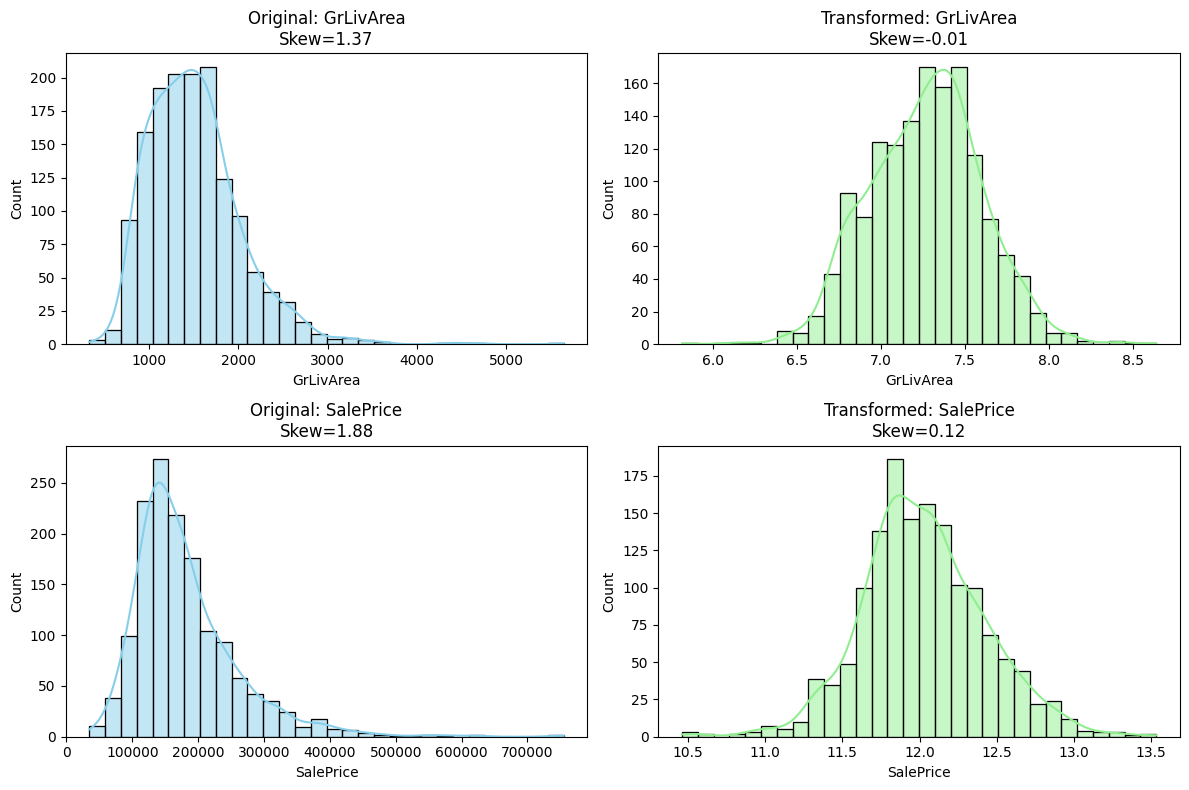

OverallQual  GrLivArea  ExterQual  BsmtQual  KitchenQual  GarageFinish  \
0               7   7.444833          3         4            3             2   
1               6   7.141245          2         4            2             2   
2               7   7.488294          3         4            3             2   
3               7   7.448916          2         3            3             1   
4               8   7.695758          3         4            3             2   
...           ...        ...        ...       ...          ...           ...   
1455            6   7.407318          2         4            2             2   
1456            6   7.637234          2         4            2             1   
1457            7   7.758333          4         3            3             2   
1458            5   6.983790          2         3            3             1   
1459            5   7.136483          3         3            2             3   

      Neighborhood  SalePrice  Foundation_CBlock  Foundation_PConc  \
0           197966  12.247699                  0                 1   
1           223214  12.109016                  1                 0   
2           197966  12.317171                  0                 1   
3           210426  11.849405                  0                 0   
4           332519  12.429220                  0                 1   
...            ...        ...                ...               ...   
1455        192850  12.072547                  0                 1   
1456        189044  12.254868                  1                 0   
1457        210426  12.493133                  0                 0   
1458        145847  11.864469                  1                 0   
1459        128222  11.901590                  1                 0   

      Foundation_Slab  Foundation_Stone  Foundation_Wood  
0                   0                 0                0  
1                   0                 0                0  
2                   0                 0                0  
3                   0                 0                0  
4                   0                 0                0  
...               ...               ...              ...  
1455                0                 0                0  
1456                0                 0                0  
1457                0                 1                0  
1458                0                 0                0  
1459                0                 0                0  

[1460 rows x 13 columns]

In [60]:
feature_transformer = FeatureTransformer()
df_transformed = feature_transformer.fit_transform(df_encoded)
df_transformed

#### Target

### Feature Scaling

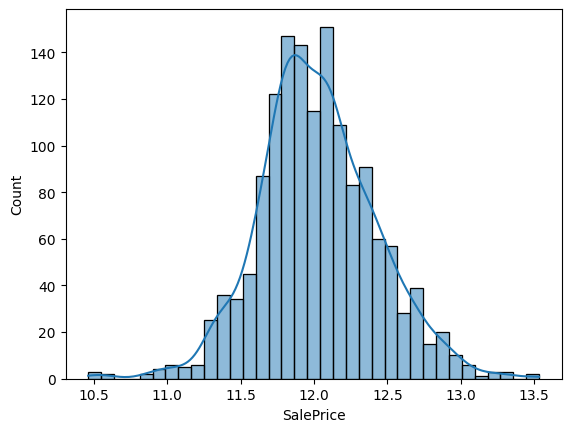

In [61]:
sbn.histplot(df_transformed[target],kde=True)
plt.show()

**However the fact the `SalePrice` is not scaled, Standardizing it is not necessary**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


class FeatureScaler(BaseEstimator, TransformerMixin):
    """
    Scale continuous numeric features in a DataFrame using different scaling strategies.

    This transformer automatically detects continuous numeric columns
    and applies the chosen scaling method. It supports inverse_transform
    for integration in pipelines. It can also visualize before/after scaling.

    Parameters
    ----------
    method : str, default="auto"
        Scaling strategy to apply:
        - "auto": automatically chooses scaler based on skew/outliers.
        - "standard": use StandardScaler (mean=0, std=1).
        - "minmax": use MinMaxScaler (scale to [0,1]).
        - "robust": use RobustScaler (median=0, IQR=1, robust to outliers).

    skew_threshold : float, default=0.5
        Absolute skew above which 'auto' mode may use RobustScaler.

    min_unique : int, default=30
        Minimum number of unique values for a column to be considered continuous.

    visualize_flag : bool, default=True
        Whether to plot boxplots before and after scaling in fit_transform.

    Attributes
    ----------
    continuous_features_ : list
        List of continuous numeric columns detected in the DataFrame.

    scalers_ : dict
        Dictionary mapping each continuous column to its fitted scaler.

    Notes on when to use each scaler
    --------------------------------
    - StandardScaler: Use when features are roughly Gaussian and free of extreme outliers.
    - MinMaxScaler: Use when you want all features in the [0,1] range, e.g., for neural networks.
    - RobustScaler: Use when features contain outliers or are highly skewed.
    - Auto mode: Automatically applies RobustScaler for skewed or repeated-value features,
      otherwise StandardScaler.
    """

    def __init__(
        self,
        method="auto",
        target=None,
        skew_threshold=0.5,
        min_unique=30,
        visualize=True,
    ):
        self.target = target
        self.method = method
        self.skew_threshold = skew_threshold
        self.min_unique = min_unique
        self.visualize = visualize
        self.continuous_features_ = []
        self.scalers_ = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame.")

        numeric_features = X.select_dtypes(include=np.number).columns.tolist()
        self.continuous_features_ = [
            col for col in numeric_features if X[col].nunique() > self.min_unique
        ]
        if self.target and self.target in self.continuous_features_:
            self.continuous_features_.remove(self.target)
        for col in self.continuous_features_:
            skewness = X[col].skew()

            if self.method == "standard":
                scaler = StandardScaler().fit(X[[col]])
            elif self.method == "minmax":
                scaler = MinMaxScaler().fit(X[[col]])
            elif self.method == "robust":
                scaler = RobustScaler().fit(X[[col]])
            else:  # auto
                if (
                    abs(skewness) > self.skew_threshold
                    or X[col].nunique() / X.shape[0] < 0.05
                ):
                    scaler = RobustScaler().fit(X[[col]])
                else:
                    scaler = StandardScaler().fit(X[[col]])

            self.scalers_[col] = scaler
        return self

    def transform(self, X):
        X_new = X.copy()
        for col, scaler in self.scalers_.items():
            X_new[col] = scaler.transform(X_new[[col]])
        if self.visualize:
            self.visualize_distribution(X, X_new)
        return X_new

    def inverse_transform(self, X):
        X_orig = X.copy()
        for col, scaler in self.scalers_.items():
            X_orig[col] = scaler.inverse_transform(X_orig[[col]])
        return X_orig

    def visualize_distribution(self, X, X_scaled=None):
        """Visualize boxplots before and after scaling for continuous features."""
        if len(self.continuous_features_) == 0:
            print("No continuous features detected.")
            return

        X_scaled = X_scaled if X_scaled is not None else self.transform(X)
        n_features = len(self.continuous_features_)

        fig, axes = plt.subplots(n_features, 2, figsize=(12, 4 * n_features))
        if n_features == 1:
            axes = np.expand_dims(axes, axis=0)  # Make 2D array for consistent indexing

        for i, col in enumerate(self.continuous_features_):
            sns.boxplot(x=X[col], ax=axes[i, 0], color="skyblue")
            axes[i, 0].set_title(f"Original: {col}")

            sns.boxplot(x=X_scaled[col], ax=axes[i, 1], color="lightgreen")
            axes[i, 1].set_title(f"Scaled: {col}")

        plt.tight_layout()
        plt.show()


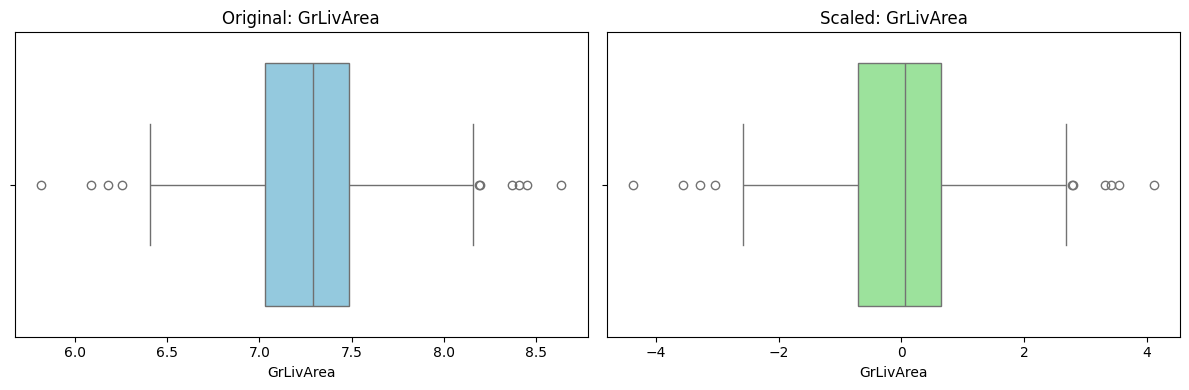

OverallQual  GrLivArea  ExterQual  BsmtQual  KitchenQual  GarageFinish  \
0               7   0.529194          3         4            3             2   
1               6  -0.381965          2         4            2             2   
2               7   0.659631          3         4            3             2   
3               7   0.541448          2         3            3             1   
4               8   1.282295          3         4            3             2   
...           ...        ...        ...       ...          ...           ...   
1455            6   0.416598          2         4            2             2   
1456            6   1.106648          2         4            2             1   
1457            7   1.470102          4         3            3             2   
1458            5  -0.854536          2         3            3             1   
1459            5  -0.396257          3         3            2             3   

      Neighborhood  SalePrice  Foundation_CBlock  Foundation_PConc  \
0           197966  12.247699                  0                 1   
1           223214  12.109016                  1                 0   
2           197966  12.317171                  0                 1   
3           210426  11.849405                  0                 0   
4           332519  12.429220                  0                 1   
...            ...        ...                ...               ...   
1455        192850  12.072547                  0                 1   
1456        189044  12.254868                  1                 0   
1457        210426  12.493133                  0                 0   
1458        145847  11.864469                  1                 0   
1459        128222  11.901590                  1                 0   

      Foundation_Slab  Foundation_Stone  Foundation_Wood  
0                   0                 0                0  
1                   0                 0                0  
2                   0                 0                0  
3                   0                 0                0  
4                   0                 0                0  
...               ...               ...              ...  
1455                0                 0                0  
1456                0                 0                0  
1457                0                 1                0  
1458                0                 0                0  
1459                0                 0                0  

[1460 rows x 13 columns]

In [63]:
feature_scaler = FeatureScaler(target="SalePrice")
df_scaled = feature_scaler.fit_transform(df_transformed)
df_scaled

### Processor Pipeline for Trained Data

In [64]:

ordinal_features = ["ExterQual", "BsmtQual", "KitchenQual","GarageFinish"]
ordinal_categories = [
    ["Po", "Fa", "TA", "Gd", "Ex"],        # ExterQual
    ["NA", "Po", "Fa", "TA", "Gd", "Ex"],  # BsmtQual
    ["Po", "Fa", "TA", "Gd", "Ex"],        # KitchenQual
    [ "NA", "Unf", "RFn", "Fin"]           # GarageFinish
]
high_cardinal_nominal_features = [ 'Neighborhood']
low_cardinal_nominal_features = ["Foundation"]

encoder = create_encoder_pipeline(ordinal_categories,ordinal_features,low_cardinal_nominal_features,high_cardinal_nominal_features,target="SalePrice")
target = "SalePrice"

def create_full_pipeline(target):
    full_pipeline = Pipeline([
        ("preprocessor",Preprocessor(cardinality_threshold=10, skew_threshold=0.5)),
        ("selector",FeatureSelector(target=target,visualize=False)),
        ("encoder",encoder),
        ("transformer", FeatureTransformer(visualize=False)),
        ("scaler", FeatureScaler(target=target))

    ])

    return full_pipeline

🔄 Fitting DataPreprocessor on data with shape: (1460, 81)
Step 1: Analyzing missing values...
SUMMMARY
                ColumnName  MissingValues  MissingPercentage    Dtype  \
PoolQC              PoolQC           1453              99.52   object   
MiscFeature    MiscFeature           1406              96.30   object   
Alley                Alley           1369              93.77   object   
Fence                Fence           1179              80.75   object   
MasVnrType      MasVnrType            872              59.73   object   
FireplaceQu    FireplaceQu            690              47.26   object   
LotFrontage    LotFrontage            259              17.74  float64   
GarageType      GarageType             81               5.55   object   
GarageYrBlt    GarageYrBlt             81               5.55  float64   
GarageFinish  GarageFinish             81               5.55   object   
GarageQual      GarageQual             81               5.55   object   
GarageCond      Garag

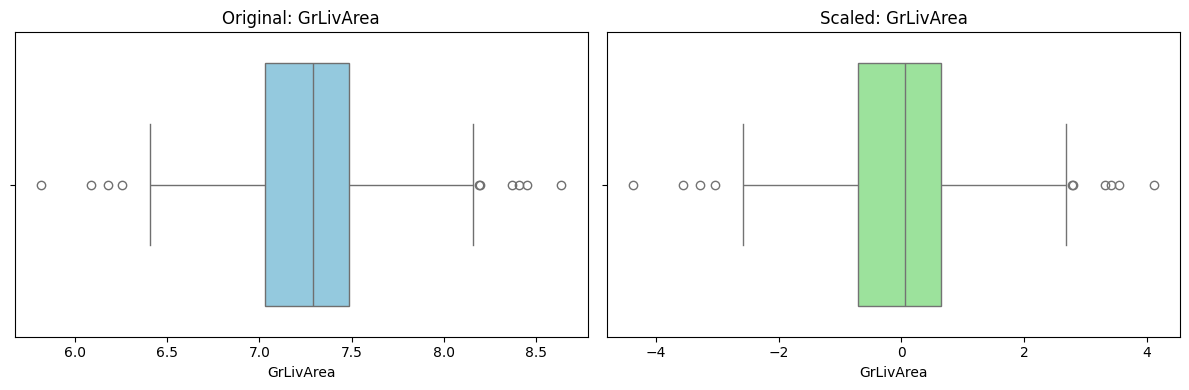

OverallQual  GrLivArea  ExterQual  BsmtQual  KitchenQual  GarageFinish  \
0               7   0.529194          3         4            3             2   
1               6  -0.381965          2         4            2             2   
2               7   0.659631          3         4            3             2   
3               7   0.541448          2         3            3             1   
4               8   1.282295          3         4            3             2   
...           ...        ...        ...       ...          ...           ...   
1455            6   0.416598          2         4            2             2   
1456            6   1.106648          2         4            2             1   
1457            7   1.470102          4         3            3             2   
1458            5  -0.854536          2         3            3             1   
1459            5  -0.396257          3         3            2             3   

      Neighborhood  SalePrice  Foundation_CBlock  Foundation_PConc  \
0           197966  12.247699                  0                 1   
1           223214  12.109016                  1                 0   
2           197966  12.317171                  0                 1   
3           210426  11.849405                  0                 0   
4           332519  12.429220                  0                 1   
...            ...        ...                ...               ...   
1455        192850  12.072547                  0                 1   
1456        189044  12.254868                  1                 0   
1457        210426  12.493133                  0                 0   
1458        145847  11.864469                  1                 0   
1459        128222  11.901590                  1                 0   

      Foundation_Slab  Foundation_Stone  Foundation_Wood  
0                   0                 0                0  
1                   0                 0                0  
2                   0                 0                0  
3                   0                 0                0  
4                   0                 0                0  
...               ...               ...              ...  
1455                0                 0                0  
1456                0                 0                0  
1457                0                 1                0  
1458                0                 0                0  
1459                0                 0                0  

[1460 rows x 13 columns]

In [65]:
train_pipeline = create_full_pipeline(target)
train_pipeline.fit(train_df)
df_train = train_pipeline.transform(train_df)
df_train

In [66]:
train_pipeline.named_steps['encoder'].named_steps["high_card_target"].mapping_

{'Neighborhood': Neighborhood
 Blmngtn    192528
 Blueste    158126
 BrDale     118436
 BrkSide    125021
 ClearCr    210573
 CollgCr    197966
 Crawfor    210426
 Edwards    128222
 Gilbert    192850
 IDOTRR     102273
 MeadowV    112409
 Mitchel    156471
 NAmes      145847
 NPkVill    154546
 NWAmes     189044
 NoRidge    332519
 NridgHt    316203
 OldTown    128226
 SWISU      145779
 Sawyer     136823
 SawyerW    186539
 Somerst    225371
 StoneBr    299722
 Timber     240768
 Veenker    223214
 dtype: int64}

### Full Pipeline for Test Data

In [67]:
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns or []

    def fit(self, X, y=None):
        return self  # nothing to learn

    def transform(self, X):
        return X[self.columns]


In [68]:
selected_features = train_pipeline.named_steps['selector'].selected_features_
selected_features

['OverallQual',
 'GrLivArea',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'KitchenQual',
 'GarageFinish',
 'Neighborhood']

In [69]:
test_pipeline = Pipeline([
    ("preprocessor",Preprocessor(cardinality_threshold=10, skew_threshold=0.5)),
    ("drop_columns", SelectColumns(columns=selected_features)),
    ("encoder",encoder),
    ("transformer", FeatureTransformer()),
    ("scaler", FeatureScaler(target="SalePrice"))

])

### Test Data Processing

🔄 Fitting DataPreprocessor on data with shape: (1459, 80)
Step 1: Analyzing missing values...
SUMMMARY
                ColumnName  MissingValues  MissingPercentage    Dtype  \
PoolQC              PoolQC           1456              99.79   object   
MiscFeature    MiscFeature           1408              96.50   object   
Alley                Alley           1352              92.67   object   
Fence                Fence           1169              80.12   object   
MasVnrType      MasVnrType            894              61.27   object   
FireplaceQu    FireplaceQu            730              50.03   object   
LotFrontage    LotFrontage            227              15.56  float64   
GarageQual      GarageQual             78               5.35   object   
GarageCond      GarageCond             78               5.35   object   
GarageYrBlt    GarageYrBlt             78               5.35  float64   
GarageFinish  GarageFinish             78               5.35   object   
GarageType      Garag

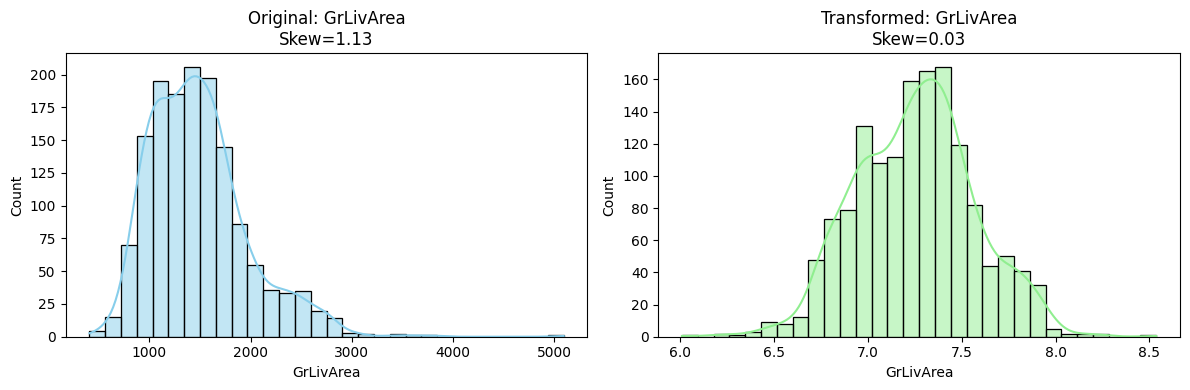

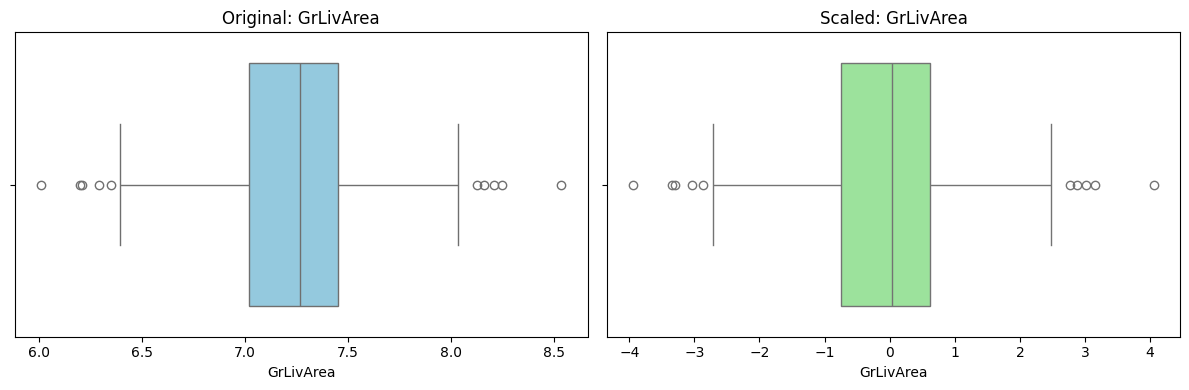

In [70]:
df_test = test_pipeline.fit_transform(test_df)

In [71]:
df_test

OverallQual  GrLivArea  ExterQual  BsmtQual  KitchenQual  GarageFinish  \
0               5  -1.442112          2         3            2             1   
1               6  -0.194908          2         3            3             1   
2               5   0.449155          2         4            2             3   
3               6   0.400213          2         3            3             3   
4               8  -0.313771          3         4            3             2   
...           ...        ...        ...       ...          ...           ...   
1454            4  -0.816336          2         3            2             1   
1455            4  -0.816336          2         3            2             1   
1456            5  -0.455313          2         3            2             1   
1457            5  -1.191104          2         4            2             1   
1458            7   1.098493          2         4            2             3   

      Neighborhood  Foundation_CBlock  Foundation_PConc  Foundation_Slab  \
0           145847                  1                 0                0   
1           145847                  1                 0                0   
2           192850                  0                 1                0   
3           192850                  0                 1                0   
4           299722                  0                 1                0   
...            ...                ...               ...              ...   
1454        112409                  1                 0                0   
1455        112409                  1                 0                0   
1456        156471                  1                 0                0   
1457        156471                  0                 1                0   
1458        156471                  0                 1                0   

      Foundation_Stone  Foundation_Wood  
0                    0                0  
1                    0                0  
2                    0                0  
3                    0                0  
4                    0                0  
...                ...              ...  
1454                 0                0  
1455                 0                0  
1456                 0                0  
1457                 0                0  
1458                 0                0  

[1459 rows x 12 columns]

### Modeling

#### Splitting the data

#### Linear Regression

In [72]:
X = df_train.drop(target,axis=1)
y = df_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
class RegressionTransformer:
    """
    Fits a single regression model (or pipeline), performs optional hyperparameter tuning,
    and evaluates standard regression metrics.
    """
    def __init__(self, model, param_grid=None, search_type='grid', cv=5, scoring='r2', n_iter=10, random_state=42):
        """
        model: sklearn estimator or pipeline
        param_grid: dict of hyperparameters to tune
        search_type: 'grid' or 'random'
        cv: number of cross-validation folds
        scoring: metric for selecting best hyperparameters
        n_iter: for RandomizedSearchCV
        """
        self.model = model
        self.param_grid = param_grid
        self.search_type = search_type
        self.cv = cv
        self.scoring = scoring
        self.n_iter = n_iter
        self.random_state = random_state
        self.best_model = None
        self.results = None

    def fit(self, X_train, y_train):
        # If hyperparameter grid is provided, do tuning
        if self.param_grid:
            if self.search_type == 'grid':
                search = GridSearchCV(self.model, self.param_grid, cv=self.cv, scoring=self.scoring, n_jobs=-1)
            elif self.search_type == 'random':
                search = RandomizedSearchCV(self.model, self.param_grid, cv=self.cv, scoring=self.scoring,
                                            n_iter=self.n_iter, n_jobs=-1, random_state=self.random_state)
            else:
                raise ValueError("search_type must be 'grid' or 'random'")
            search.fit(X_train, y_train)
            self.best_model = search.best_estimator_
            self.best_params_ = search.best_params_
        else:
            self.model.fit(X_train, y_train)
            self.best_model = self.model
            self.best_params_ = None
        return self

    def evaluate(self, X_test, y_test):
        if self.best_model is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        y_pred = self.best_model.predict(X_test)
        metrics = {
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MedianAE": float(median_absolute_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred)
        }
        self.results = pd.DataFrame(metrics, index=[0])
        return metrics

    def fit_evaluate(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        return self.evaluate(X_test, y_test)


In [74]:
# ───────────────────────────────────────────────────────────────
# ✅ 2. New Manager Class to Add & Train Models One-by-One
# ───────────────────────────────────────────────────────────────
class RegressionManager:
    """
    Manages multiple models, allows adding them dynamically,
    trains only the newly added ones, and stores results.
    """
    def __init__(self):
        self.models = {}
        self.trained_models = set()
        self.all_results = []

    def add_model(self, name, model, param_grid=None, search_type='grid',
                  cv=5, scoring='r2', n_iter=10, random_state=42):
        """
        Adds a model but does NOT train it immediately.
        """
        self.models[name] = {
            "model": model,
            "param_grid": param_grid,
            "search_type": search_type,
            "cv": cv,
            "scoring": scoring,
            "n_iter": n_iter,
            "random_state": random_state
        }
        print(f"✅ Model '{name}' added.")

    def train_model(self, name, X_train, X_test, y_train, y_test):
        """
        Trains ONLY the specified model if not already trained.
        """
        if name not in self.models:
            print(f"❌ Model '{name}' not found.")
            return

        if name in self.trained_models:
            print(f"⏭ Model '{name}' already trained. Skipping.")
            return

        cfg = self.models[name]
        print(f"▶ Training model: {name}")

        transformer = RegressionTransformer(
            model=cfg["model"],
            param_grid=cfg["param_grid"],
            search_type=cfg["search_type"],
            cv=cfg["cv"],
            scoring=cfg["scoring"],
            n_iter=cfg["n_iter"],
            random_state=cfg["random_state"]
        )

        metrics = transformer.fit_evaluate(X_train, X_test, y_train, y_test)

        self.all_results.append({
            "Model": name,
            "Best Params": transformer.best_params_,
            **metrics
        })
        self.trained_models.add(name)
        print(f"✅ Training complete for '{name}'.")

    def get_results(self):
        """
        Returns all training results in a DataFrame.
        """
        return pd.DataFrame(self.all_results)


In [75]:
param_grid = {
    'linereg__fit_intercept': [True, False]  # only if inside a pipeline
}

line_reg = Pipeline([
    ('linereg', LinearRegression())
])
linereg_transformer = RegressionTransformer(model=line_reg, param_grid=param_grid, search_type='grid', cv=5)
linereg_transformer.fit_evaluate(X_train, X_test, y_train, y_test)


{'MSE': 0.028453771314668183,
 'RMSE': 0.028453771314668183,
 'MAE': 0.12330354265530116,
 'MedianAE': 0.08812894320953557,
 'R2': 0.847523602281904}

#### Stochastic Gradient Regressor

In [76]:
sgd_pipeline = Pipeline([
  ('sgd', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
])

# Hyperparameter grid
sgd_param_grid = {
    'sgd__alpha': [0.0001, 0.001, 0.01],        # regularization
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling'],
    'sgd__eta0': [0.01, 0.1, 0.5]               # initial learning rate
}

# Transformer
sgd_transformer = RegressionTransformer(model=sgd_pipeline,
                                        param_grid=sgd_param_grid,
                                        search_type='grid', cv=5)

# Fit and evaluate
sgd_transformer.fit_evaluate(X_train, X_test, y_train, y_test)

{'MSE': 3.2494651133265884e+37,
 'RMSE': 3.2494651133265884e+37,
 'MAE': 5.42511479068895e+18,
 'MedianAE': 5.591130559357217e+18,
 'R2': -1.7413042703947118e+38}

#### Huber Regressor

In [77]:
huber_pipeline = Pipeline([
    ('huber', HuberRegressor(max_iter=1000))
])

# Hyperparameter grid
huber_param_grid = {
    'huber__epsilon': [1.1, 1.35, 1.5],
    'huber__alpha': [0.0001, 0.001, 0.01]
}

# Transformer
huber_transformer = RegressionTransformer(model=huber_pipeline,
                                          param_grid=huber_param_grid,
                                          search_type='grid', cv=5)

# Fit and evaluate
huber_transformer.fit_evaluate(X_train, X_test, y_train, y_test)

{'MSE': 2.57391656459322,
 'RMSE': 2.57391656459322,
 'MAE': 1.2937987168490097,
 'MedianAE': 1.1144855604004134,
 'R2': -12.792952837636443}

#### Ridge

In [78]:
ridge_pipeline = Pipeline([
    ('ridge', Ridge())
])

ridge_param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'ridge__fit_intercept': [True, False]
}

ridge_transformer = RegressionTransformer(ridge_pipeline, ridge_param_grid, 'grid', cv=5)
ridge_transformer.fit_evaluate(X_train, X_test, y_train, y_test)

{'MSE': 0.028344833888090445,
 'RMSE': 0.028344833888090445,
 'MAE': 0.12253696523274939,
 'MedianAE': 0.08816527294447862,
 'R2': 0.8481073697620585}

In [79]:
lasso_pipeline = Pipeline([
    ('lasso', Lasso(max_iter=5000))
])

lasso_param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1.0],
    'lasso__fit_intercept': [True, False]
}

lasso_transformer = RegressionTransformer(lasso_pipeline, lasso_param_grid, 'grid', cv=5)
lasso_transformer.fit_evaluate(X_train, X_test, y_train, y_test)

{'MSE': 0.028330155224078567,
 'RMSE': 0.028330155224078567,
 'MAE': 0.12256025750734387,
 'MedianAE': 0.08921527991837319,
 'R2': 0.8481860289242164}

#### ElasticNet

In [80]:
en_pipeline = Pipeline([
    ('en', ElasticNet(max_iter=5000))
])
en_param_grid = {
    'en__alpha': [0.001, 0.01, 0.1, 1.0],
    'en__l1_ratio': [0.2, 0.5, 0.8],
    'en__fit_intercept': [True, False]
}

en_transformer = RegressionTransformer(en_pipeline, en_param_grid, 'grid', cv=5)
en_transformer.fit_evaluate(X_train, X_test, y_train, y_test)


{'MSE': 0.028338292035089883,
 'RMSE': 0.028338292035089883,
 'MAE': 0.12261392738321758,
 'MedianAE': 0.0887241687107263,
 'R2': 0.848142425859505}

#### Decision Tree Regressor

In [81]:
from sklearn.tree import DecisionTreeRegressor

dt_pipeline = Pipeline([
    ('dt', DecisionTreeRegressor(random_state=42))
])

dt_param_grid = {
    'dt__max_depth': [None, 5, 10, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

dt_transformer = RegressionTransformer(dt_pipeline, dt_param_grid, 'grid', cv=5)
dt_transformer.fit_evaluate(X_train, X_test, y_train, y_test)

{'MSE': 0.030781148351952482,
 'RMSE': 0.030781148351952482,
 'MAE': 0.12579411934597917,
 'MedianAE': 0.09471304646571355,
 'R2': 0.8350517909760339}

#### Random Forest Regressor

In [82]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=42,n_jobs=-1))
])

rf_param_grid = {
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': [1.0, 'sqrt', 0.8]
}

rf_transformer = RegressionTransformer(rf_pipeline, rf_param_grid, 'grid', cv=5)
rf_transformer.fit_evaluate(X_train, X_test, y_train, y_test)


{'MSE': 0.025205099184451164,
 'RMSE': 0.025205099184451164,
 'MAE': 0.1088619822511194,
 'MedianAE': 0.07259573868793101,
 'R2': 0.8649323955945609}

#### XGBoost Regressor

In [83]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

xgb_param_grid = {
    # 'xgb__n_estimators': [100, 200,500],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.7, 1.0],
    'xgb__colsample_bytree': [0.7, 1.0]
}

xgb_transformer = RegressionTransformer(xgb_pipeline, xgb_param_grid, 'grid', cv=5)
xgb_transformer.fit_evaluate(X_train, X_test, y_train, y_test)

{'MSE': 0.024440628952774074,
 'RMSE': 0.024440628952774074,
 'MAE': 0.11124588509094908,
 'MedianAE': 0.07981503747140106,
 'R2': 0.8690289937502069}

In [84]:
xgb_transformer.best_params_

{'xgb__colsample_bytree': 0.7,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__subsample': 1.0}

#### AdaBoost Tree Regressor

In [85]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

# Using a DecisionTree as the base estimator
ada_pipeline = Pipeline([
    ('ada', AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), random_state=42))
])

ada_param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'ada__estimator__max_depth': [1, 2, 3, 5]
}

ada_transformer = RegressionTransformer(ada_pipeline, ada_param_grid, 'grid', cv=5)
ada_transformer.fit_evaluate(X_train, X_test, y_train, y_test)


{'MSE': 0.027929996968740323,
 'RMSE': 0.027929996968740323,
 'MAE': 0.12249511176483593,
 'MedianAE': 0.09006995864496137,
 'R2': 0.8503303734687893}

#### Support Vectore Regressor

In [86]:
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

In [87]:
# svr_pipeline = Pipeline([
#     ('svr', LinearSVR(max_iter=100))
# ])

# # Hyperparameter grid
# svr_param_grid = {
#     # 'svr__kernel': ['linear'],
#     'svr__C': [0.1, 1, 10, 100],           # Regularization parameter
#     'svr__epsilon': [0.01, 0.1, 0.2, 0.5], # Tube width
#     # 'svr__degree': [2, 3, 4]               # Only used for 'poly' kernel
# }

# # Transformer
# svr_transformer = RegressionTransformer(svr_pipeline, svr_param_grid, 'grid', cv=5)

# # Fit and evaluate
# svr_transformer.fit_evaluate(X_train, X_test, y_train, y_test)
# # print("SVR Metrics:", svr_metrics)
# # print("Best Params:", svr_transformer.best_params_)

### Full Modeling Pipeline

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# ───────────────────────────────────────────────────────────────
# ✅ 1. Base Class: RegressionTransformer (UNCHANGED)
# ───────────────────────────────────────────────────────────────
class RegressionTransformer:
    """
    Fits a single regression model (or pipeline), performs optional hyperparameter tuning,
    and evaluates standard regression metrics.
    """
    def __init__(self, model, param_grid=None, search_type='grid', cv=5, scoring='r2', n_iter=10, random_state=42):
        self.model = model
        self.param_grid = param_grid
        self.search_type = search_type
        self.cv = cv
        self.scoring = scoring
        self.n_iter = n_iter
        self.random_state = random_state
        self.best_model = None
        self.results = None
        self.best_params_ = None

    def fit(self, X_train, y_train):
        if self.param_grid:
            if self.search_type == 'grid':
                search = GridSearchCV(self.model, self.param_grid, cv=self.cv, scoring=self.scoring, n_jobs=-1)
            elif self.search_type == 'random':
                search = RandomizedSearchCV(
                    self.model,
                    self.param_grid,
                    cv=self.cv,
                    scoring=self.scoring,
                    n_iter=self.n_iter,
                    n_jobs=-1,
                    random_state=self.random_state
                )
            else:
                raise ValueError("search_type must be 'grid' or 'random'")
            search.fit(X_train, y_train)
            self.best_model = search.best_estimator_
            self.best_params_ = search.best_params_
        else:
            self.model.fit(X_train, y_train)
            self.best_model = self.model
            self.best_params_ = None
        return self

    def evaluate(self, X_test, y_test):
        if self.best_model is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        y_pred = self.best_model.predict(X_test)
        metrics = {
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred) ** 0.5,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MedianAE": float(median_absolute_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred)
        }
        self.results = pd.DataFrame(metrics, index=[0])
        return metrics

    def fit_evaluate(self, X_train, X_test, y_train, y_test):
        self.fit(X_train, y_train)
        return self.evaluate(X_test, y_test)

# ───────────────────────────────────────────────────────────────
# ✅ 2. New Manager Class to Add & Train Models One-by-One
# ───────────────────────────────────────────────────────────────
class RegressionManager:
    """
    Manages multiple models, allows adding them dynamically,
    trains only the newly added ones, and stores results.
    """
    def __init__(self):
        self.models = {}
        self.trained_models = set()
        self.all_results = []

    def add_model(self, name, model, param_grid=None, search_type='grid',
                  cv=5, scoring='r2', n_iter=10, random_state=42):
        """
        Adds a model but does NOT train it immediately.
        """
        self.models[name] = {
            "model": model,
            "param_grid": param_grid,
            "search_type": search_type,
            "cv": cv,
            "scoring": scoring,
            "n_iter": n_iter,
            "random_state": random_state
        }
        print(f"✅ Model '{name}' added.")

    def train_model(self, name, X_train, X_test, y_train, y_test):
        """
        Trains ONLY the specified model if not already trained.
        """
        if name not in self.models:
            print(f"❌ Model '{name}' not found.")
            return

        if name in self.trained_models:
            print(f"⏭ Model '{name}' already trained. Skipping.")
            return

        cfg = self.models[name]
        print(f"▶ Training model: {name}")

        transformer = RegressionTransformer(
            model=cfg["model"],
            param_grid=cfg["param_grid"],
            search_type=cfg["search_type"],
            cv=cfg["cv"],
            scoring=cfg["scoring"],
            n_iter=cfg["n_iter"],
            random_state=cfg["random_state"]
        )

        metrics = transformer.fit_evaluate(X_train, X_test, y_train, y_test)

        self.all_results.append({
            "Model": name,
            "Best Params": transformer.best_params_,
            "Estimator":transformer.best_model,
            **metrics
        })
        self.trained_models.add(name)
        print(f"✅ Training complete for '{name}'.")

    def get_results(self):
        """
        Returns all training results in a DataFrame.
        """
        return pd.DataFrame(self.all_results)


In [89]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
# ──────────────────────────────
# Initialize manager
# ──────────────────────────────
manager = RegressionManager()

# ──────────────────────────────
# 1. Linear Regression
# ──────────────────────────────
lr_pipeline = Pipeline([('linreg', LinearRegression())])
lr_param_grid = {'linreg__fit_intercept': [True, False]}

manager.add_model("LinearRegression", lr_pipeline, lr_param_grid)
manager.train_model("LinearRegression", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 2. Ridge Regression
# ──────────────────────────────
ridge_pipeline = Pipeline([('ridge', Ridge())])
ridge_param_grid = {'ridge__alpha': [0.1, 1.0, 10.0], 'ridge__fit_intercept': [True, False]}

manager.add_model("Ridge", ridge_pipeline, ridge_param_grid)
manager.train_model("Ridge", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 3. Lasso Regression
# ──────────────────────────────
lasso_pipeline = Pipeline([('lasso', Lasso(max_iter=5000))])
lasso_param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0], 'lasso__fit_intercept': [True, False]}

manager.add_model("Lasso", lasso_pipeline, lasso_param_grid)
manager.train_model("Lasso", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 4. ElasticNet Regression
# ──────────────────────────────
en_pipeline = Pipeline([('en', ElasticNet(max_iter=5000))])
en_param_grid = {'en__alpha': [0.001, 0.01, 0.1, 1.0],
                 'en__l1_ratio': [0.2, 0.5, 0.8],
                 'en__fit_intercept': [True, False]}

manager.add_model("ElasticNet", en_pipeline, en_param_grid)
manager.train_model("ElasticNet", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 5. SGD Regressor
# ──────────────────────────────
sgd_pipeline = Pipeline([('sgd', SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))])
sgd_param_grid = {'sgd__alpha': [0.0001, 0.001, 0.01],
                  'sgd__learning_rate': ['constant', 'optimal', 'invscaling'],
                  'sgd__eta0': [0.01, 0.1, 0.5]}

manager.add_model("SGDRegressor", sgd_pipeline, sgd_param_grid)
manager.train_model("SGDRegressor", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 6. Huber Regressor
# ──────────────────────────────
huber_pipeline = Pipeline([('huber', HuberRegressor(max_iter=1000))])
huber_param_grid = {'huber__epsilon': [1.1, 1.35, 1.5],
                    'huber__alpha': [0.0001, 0.001, 0.01]}

manager.add_model("HuberRegressor", huber_pipeline, huber_param_grid)
manager.train_model("HuberRegressor", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 7. Decision Tree Regressor
# ──────────────────────────────
dt_pipeline = Pipeline([('dt', DecisionTreeRegressor(random_state=42))])
dt_param_grid = {'dt__max_depth': [None, 5, 10, 20],
                 'dt__min_samples_split': [2, 5, 10],
                 'dt__min_samples_leaf': [1, 2, 4]}

manager.add_model("DecisionTree", dt_pipeline, dt_param_grid)
manager.train_model("DecisionTree", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 8. Random Forest Regressor
# ──────────────────────────────
rf_pipeline = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])
rf_param_grid = {'rf__max_depth': [None, 10, 20],
                 'rf__min_samples_split': [2, 5],
                 'rf__min_samples_leaf': [1, 2],
                 'rf__max_features': [1.0, 'sqrt', 0.8]}

manager.add_model("RandomForest", rf_pipeline, rf_param_grid)
manager.train_model("RandomForest", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 9. AdaBoost Regressor
# ──────────────────────────────
ada_pipeline = Pipeline([('ada', AdaBoostRegressor(random_state=42))])
ada_param_grid = {'ada__n_estimators': [50, 100, 200],
                  'ada__learning_rate': [0.01, 0.05, 0.1, 0.5]}

manager.add_model("AdaBoost", ada_pipeline, ada_param_grid)
manager.train_model("AdaBoost", X_train, X_test, y_train, y_test)

# ──────────────────────────────
# 10. XGBoost Regressor
# ──────────────────────────────
xgb_pipeline = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))])
xgb_param_grid = {'xgb__max_depth': [3, 5, 7],
                  'xgb__learning_rate': [0.01, 0.05, 0.1],
                  'xgb__subsample': [0.7, 1.0],
                  'xgb__colsample_bytree': [0.7, 1.0]}

manager.add_model("XGBoost", xgb_pipeline, xgb_param_grid)
manager.train_model("XGBoost", X_train, X_test, y_train, y_test)

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ──────────────────────────────
# 11. Linear SVR
# ──────────────────────────────
# svr_pipeline = Pipeline([('svr', LinearSVR(random_state=42,max_iter=10000))])
# svr_param_grid = {'svr__C': [0.1, 1, 10, 100],
#                   'svr__epsilon': [0.01, 0.1, 0.2, 0.5]}

# manager.add_model("LinearSVR", svr_pipeline, svr_param_grid)
# manager.train_model("LinearSVR", X_train, X_test, y_train, y_test)


# ──────────────────────────────
# View all results
# ──────────────────────────────
models_df = manager.get_results()
models_df


✅ Model 'LinearRegression' added.
▶ Training model: LinearRegression
✅ Training complete for 'LinearRegression'.
✅ Model 'Ridge' added.
▶ Training model: Ridge
✅ Training complete for 'Ridge'.
✅ Model 'Lasso' added.
▶ Training model: Lasso
✅ Training complete for 'Lasso'.
✅ Model 'ElasticNet' added.
▶ Training model: ElasticNet
✅ Training complete for 'ElasticNet'.
✅ Model 'SGDRegressor' added.
▶ Training model: SGDRegressor
✅ Training complete for 'SGDRegressor'.
✅ Model 'HuberRegressor' added.
▶ Training model: HuberRegressor
✅ Training complete for 'HuberRegressor'.
✅ Model 'DecisionTree' added.
▶ Training model: DecisionTree
✅ Training complete for 'DecisionTree'.
✅ Model 'RandomForest' added.
▶ Training model: RandomForest
✅ Training complete for 'RandomForest'.
✅ Model 'AdaBoost' added.
▶ Training model: AdaBoost
✅ Training complete for 'AdaBoost'.
✅ Model 'XGBoost' added.
▶ Training model: XGBoost
✅ Training complete for 'XGBoost'.


Model                                        Best Params  \
0  LinearRegression                    {'linreg__fit_intercept': True}   
1             Ridge  {'ridge__alpha': 10.0, 'ridge__fit_intercept':...   
2             Lasso  {'lasso__alpha': 0.001, 'lasso__fit_intercept'...   
3        ElasticNet  {'en__alpha': 0.001, 'en__fit_intercept': True...   
4      SGDRegressor  {'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__...   
5    HuberRegressor      {'huber__alpha': 0.01, 'huber__epsilon': 1.5}   
6      DecisionTree  {'dt__max_depth': 10, 'dt__min_samples_leaf': ...   
7      RandomForest  {'rf__max_depth': 10, 'rf__max_features': 'sqr...   
8          AdaBoost  {'ada__learning_rate': 0.05, 'ada__n_estimator...   
9           XGBoost  {'xgb__colsample_bytree': 0.7, 'xgb__learning_...   

                                           Estimator           MSE  \
0                               (LinearRegression())  2.845377e-02   
1                                (Ridge(alpha=10.0))  2.834483e-02   
2                (Lasso(alpha=0.001, max_iter=5000))  2.833016e-02   
3  (ElasticNet(alpha=0.001, l1_ratio=0.8, max_ite...  2.833829e-02   
4  (SGDRegressor(alpha=0.01, learning_rate='optim...  3.249465e+37   
5  (HuberRegressor(alpha=0.01, epsilon=1.5, max_i...  2.573917e+00   
6  (DecisionTreeRegressor(max_depth=10, min_sampl...  3.078115e-02   
7  ((DecisionTreeRegressor(max_depth=10, max_feat...  2.520510e-02   
8  ((DecisionTreeRegressor(max_depth=3, random_st...  3.117492e-02   
9  (XGBRegressor(base_score=None, booster=None, c...  2.444063e-02   

           RMSE           MAE      MedianAE            R2  
0  1.686825e-01  1.233035e-01  8.812894e-02  8.475236e-01  
1  1.683592e-01  1.225370e-01  8.816527e-02  8.481074e-01  
2  1.683156e-01  1.225603e-01  8.921528e-02  8.481860e-01  
3  1.683398e-01  1.226139e-01  8.872417e-02  8.481424e-01  
4  5.700408e+18  5.425115e+18  5.591131e+18 -1.741304e+38  
5  1.604343e+00  1.293799e+00  1.114486e+00 -1.279295e+01  
6  1.754456e-01  1.257941e-01  9.471305e-02  8.350518e-01  
7  1.587611e-01  1.088620e-01  7.259574e-02  8.649324e-01  
8  1.765642e-01  1.301943e-01  9.230205e-02  8.329417e-01  
9  1.563350e-01  1.112459e-01  7.981504e-02  8.690290e-01

In [91]:
models_df = models_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

In [92]:
models_df

Model                                        Best Params  \
0           XGBoost  {'xgb__colsample_bytree': 0.7, 'xgb__learning_...   
1      RandomForest  {'rf__max_depth': 10, 'rf__max_features': 'sqr...   
2             Lasso  {'lasso__alpha': 0.001, 'lasso__fit_intercept'...   
3        ElasticNet  {'en__alpha': 0.001, 'en__fit_intercept': True...   
4             Ridge  {'ridge__alpha': 10.0, 'ridge__fit_intercept':...   
5  LinearRegression                    {'linreg__fit_intercept': True}   
6      DecisionTree  {'dt__max_depth': 10, 'dt__min_samples_leaf': ...   
7          AdaBoost  {'ada__learning_rate': 0.05, 'ada__n_estimator...   
8    HuberRegressor      {'huber__alpha': 0.01, 'huber__epsilon': 1.5}   
9      SGDRegressor  {'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__...   

                                           Estimator           MSE  \
0  (XGBRegressor(base_score=None, booster=None, c...  2.444063e-02   
1  ((DecisionTreeRegressor(max_depth=10, max_feat...  2.520510e-02   
2                (Lasso(alpha=0.001, max_iter=5000))  2.833016e-02   
3  (ElasticNet(alpha=0.001, l1_ratio=0.8, max_ite...  2.833829e-02   
4                                (Ridge(alpha=10.0))  2.834483e-02   
5                               (LinearRegression())  2.845377e-02   
6  (DecisionTreeRegressor(max_depth=10, min_sampl...  3.078115e-02   
7  ((DecisionTreeRegressor(max_depth=3, random_st...  3.117492e-02   
8  (HuberRegressor(alpha=0.01, epsilon=1.5, max_i...  2.573917e+00   
9  (SGDRegressor(alpha=0.01, learning_rate='optim...  3.249465e+37   

           RMSE           MAE      MedianAE            R2  
0  1.563350e-01  1.112459e-01  7.981504e-02  8.690290e-01  
1  1.587611e-01  1.088620e-01  7.259574e-02  8.649324e-01  
2  1.683156e-01  1.225603e-01  8.921528e-02  8.481860e-01  
3  1.683398e-01  1.226139e-01  8.872417e-02  8.481424e-01  
4  1.683592e-01  1.225370e-01  8.816527e-02  8.481074e-01  
5  1.686825e-01  1.233035e-01  8.812894e-02  8.475236e-01  
6  1.754456e-01  1.257941e-01  9.471305e-02  8.350518e-01  
7  1.765642e-01  1.301943e-01  9.230205e-02  8.329417e-01  
8  1.604343e+00  1.293799e+00  1.114486e+00 -1.279295e+01  
9  5.700408e+18  5.425115e+18  5.591131e+18 -1.741304e+38

In [94]:
best_estimator = models_df.loc[0,"Estimator"]

In [95]:
results = best_estimator.predict(df_test)

In [96]:
results_df = pd.DataFrame({"Id":test_df.Id.values,"SalePrice":np.expm1(results)})

In [97]:
results_df.to_csv("submission.csv",index=False)

In [98]:
results_df

Id      SalePrice
0     1461  118734.687500
1     1462  147402.562500
2     1463  171833.812500
3     1464  185956.625000
4     1465  212796.640625
...    ...            ...
1454  2915   90633.726562
1455  2916   90633.726562
1456  2917  136445.328125
1457  2918  134039.812500
1458  2919  204354.281250

[1459 rows x 2 columns]